# Power C100

In [54]:
import httpx
import socksio
from datetime import datetime, timedelta, timezone
import mplhep
import hist
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import json
import matplotlib.dates as mdates
import re
from IPython.display import display

## Download measurements from Prometheus

In [2]:
queries = [
    ("gpu_power", "nvidia_power_watts", "1s"),
    ("bmc_power", 'ipmi_dcmi_power_consumption_watts{job="ipmi_g01"}', "1s"),
    (
        "cpu",
        '(sum by(instance) (irate(node_cpu_seconds_total{instance="ef-tb-g01:9100", mode !="idle"}[10s])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total[10s])))) * 100',
        "10s",
    ),
    (
        "cpu_freq",
        'avg(node_cpu_scaling_frequency_hertz{instance="ef-tb-g01:9100"})',
        "10s",
    ),
    (
        "cpu_freq_max",
        'max(node_cpu_scaling_frequency_hertz{instance="ef-tb-g01:9100"})',
        "10s",
    ),
    (
        "cpu_freq_min",
        'min(node_cpu_scaling_frequency_hertz{instance="ef-tb-g01:9100"})',
        "10s",
    ),
]

start_local = datetime(year=2025, month=6, day=17, hour=10, minute=0, second=0)
end_local = datetime(year=2025, month=6, day=17, hour=14, minute=30, second=0)

start = start_local.astimezone(timezone.utc)
end = end_local.astimezone(timezone.utc)

delta = timedelta(hours=3)
# end = datetime(year=2025, month=6, day=13, hour=10, minute=5, second=0, tzinfo=timezone.utc)

this_result = {}

with (
    httpx.Client(
        # proxy="socks5://localhost:8888",
    ) as client
):
    for key, query, step in queries:
        accumulated = []
        now = start
        while now < end:
            window_start = now.isoformat().replace("+00:00", "Z")
            window_end = min(end, now + delta).isoformat().replace("+00:00", "Z")
            print(window_start, window_end)
            now += delta

            url = "http://ef-tb-f01:9090/api/v1/query_range"
            r = client.get(
                url,
                params={
                    "query": query,
                    "start": window_start,
                    "end": window_end,
                    "step": step,
                },
            )
            print(r.url)
            data = r.json()
            values = data["data"]["result"][0]["values"]

            if len(accumulated) > 0:
                first_new, _ = values[0]
                last_existing, _ = accumulated[-1]
                if first_new == last_existing:
                    values = values[1:]  # drop the first value

            # print(values)
            accumulated += values

        this_result[key] = accumulated

fname = (
    Path.cwd()
    / f"result_{start_local:%Y-%m-%dT%H-%M-%S}__{end_local:%Y-%m-%dT%H-%M-%S}.json"
)

# with fname.open("w") as f:
#     json.dump(this_result, f)
# print(fname)

2025-06-17T08:00:00Z 2025-06-17T11:00:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=nvidia_power_watts&start=2025-06-17T08%3A00%3A00Z&end=2025-06-17T11%3A00%3A00Z&step=1s
2025-06-17T11:00:00Z 2025-06-17T12:30:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=nvidia_power_watts&start=2025-06-17T11%3A00%3A00Z&end=2025-06-17T12%3A30%3A00Z&step=1s
2025-06-17T08:00:00Z 2025-06-17T11:00:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=ipmi_dcmi_power_consumption_watts%7Bjob%3D%22ipmi_g01%22%7D&start=2025-06-17T08%3A00%3A00Z&end=2025-06-17T11%3A00%3A00Z&step=1s
2025-06-17T11:00:00Z 2025-06-17T12:30:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=ipmi_dcmi_power_consumption_watts%7Bjob%3D%22ipmi_g01%22%7D&start=2025-06-17T11%3A00%3A00Z&end=2025-06-17T12%3A30%3A00Z&step=1s
2025-06-17T08:00:00Z 2025-06-17T11:00:00Z
http://ef-tb-f01:9090/api/v1/query_range?query=%28sum+by%28instance%29+%28irate%28node_cpu_seconds_total%7Binstance%3D%22ef-tb-g01%3A9100%22%2C+mode+%21%3D%22idle%22%7D%5B1

In [289]:
# result_file = Path.cwd() / "result.json"
# with result_file.open("w") as f:
#     json.dump(result, f)

# with result_file.open("r") as f:
# result = json.load(f)

In [3]:
result_files = [
    "result_2025-06-13.json",
    "result_2025-06-17T10-00-00__2025-06-17T14-30-00.json",
]

result = {}

for fname in result_files:
    with (Path.cwd().parent / fname).open("r") as f:
        data = json.load(f)
        for key, values in data.items():
            result.setdefault(key, []).extend(values)


## Build time series dataset from measurements

In [4]:
# result

In [5]:
arr = np.array(result["bmc_power"]).T

print(arr)

bmc_times = np.array(arr[0], dtype=int)
bmc_power = np.array(arr[1], dtype=int)
bmc_times = pd.to_datetime(bmc_times, unit="s", utc=True)

arr = np.array(result["gpu_power"]).T

df_bmc = pd.DataFrame({"bmc_power": bmc_power})
df_bmc.index = bmc_times

gpu_times = np.array(arr[0], dtype=int)
gpu_power = np.array(arr[1], dtype=float)
gpu_times = pd.to_datetime(gpu_times, unit="s", utc=True)

df_gpu = pd.DataFrame({"gpu_power": gpu_power})
df_gpu.index = gpu_times

arr = np.array(result["cpu"]).T

cpu_times = np.array(arr[0], dtype=int)
cpu_perc = np.array(arr[1], dtype=float)
cpu_times = pd.to_datetime(cpu_times, unit="s", utc=True)


df_cpu = pd.DataFrame({"cpu": cpu_perc})
df_cpu.index = cpu_times

df = df_gpu.join(df_bmc).join(df_cpu)

df_cpu_freq = pd.DataFrame()

for q in ["cpu_freq", "cpu_freq_max", "cpu_freq_min"]:
    arr = np.array(result[q]).T
    values = np.array(arr[1], dtype=float) / 1e9
    times = pd.to_datetime(arr[0].astype(int), unit="s", utc=True)

    df_cpu_freq = pd.DataFrame({q: values})
    df_cpu_freq.index = times

    df = df.join(df_cpu_freq)
    df[q] = df[q].bfill()

df["cpu"] = df["cpu"].bfill()


df.index += timedelta(hours=2)

df.index = df.index.tz_localize(None)

# print(df.cpu.head(50))
# print(df.cpu.tail(50))

df

# df.cpu.head(50)
# df = pd.DataFrame()
# df["time"] = pd.to_datetime(result["ipmi_dcmi_power_consumption_watts")

[['1749801600' '1749801601' '1749801602' ... '1750163398' '1750163399'
  '1750163400']
 ['120' '120' '120' ... '135' '127' '183']]


,gpu_power,bmc_power,cpu,cpu_freq,cpu_freq_max,cpu_freq_min
2025-06-13 10:00:00,7.33,120.0,17.761008,2.258596,3.694154,2.25
2025-06-13 10:00:01,7.33,120.0,17.761008,2.267194,3.694272,2.25
2025-06-13 10:00:02,7.33,120.0,17.761008,2.267194,3.694272,2.25
2025-06-13 10:00:03,7.33,120.0,17.761008,2.267194,3.694272,2.25
2025-06-13 10:00:04,7.33,120.0,17.761008,2.267194,3.694272,2.25
...,...,...,...,...,...,...
2025-06-17 14:29:56,8.19,135.0,0.149156,2.267171,3.693156,2.25
2025-06-17 14:29:57,8.19,128.0,0.149156,2.267171,3.693156,2.25
2025-06-17 14:29:58,8.24,135.0,0.149156,2.267171,3.693156,2.25
2025-06-17 14:29:59,7.97,127.0,0.149156,2.267171,3.693156,2.25


<Axes: >

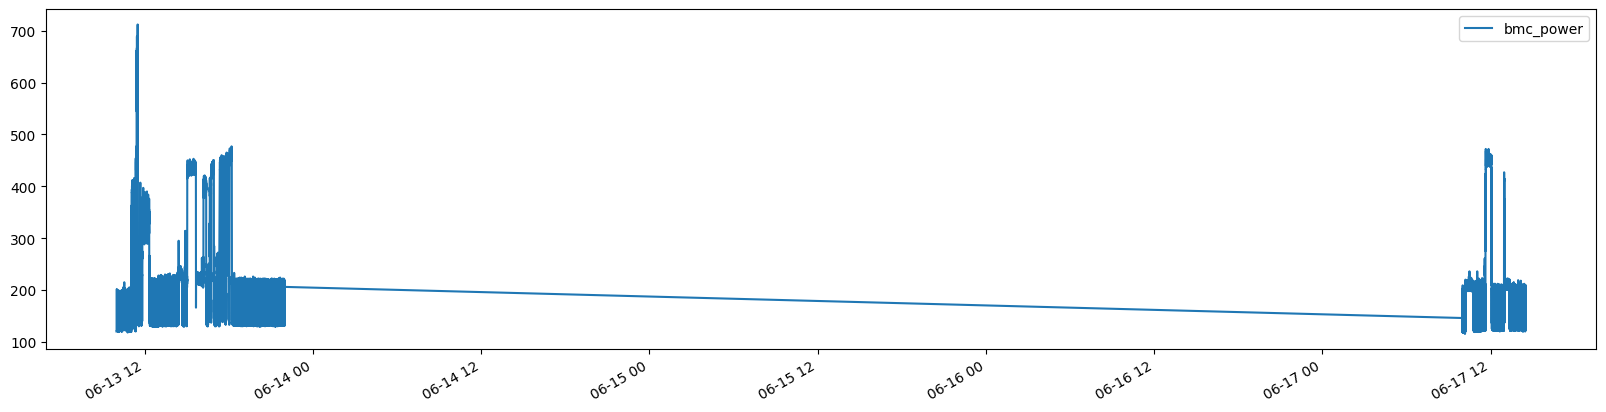

In [6]:
fig, ax = plt.subplots(figsize=(20, 5))
df.plot(y="bmc_power", ax=ax)

In [7]:
def apply_date_format(*axs):
    locator = mdates.HourLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    for ax in axs:
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

    # for ax in axs[1:]:
    #     ax.set_xticklabels([])

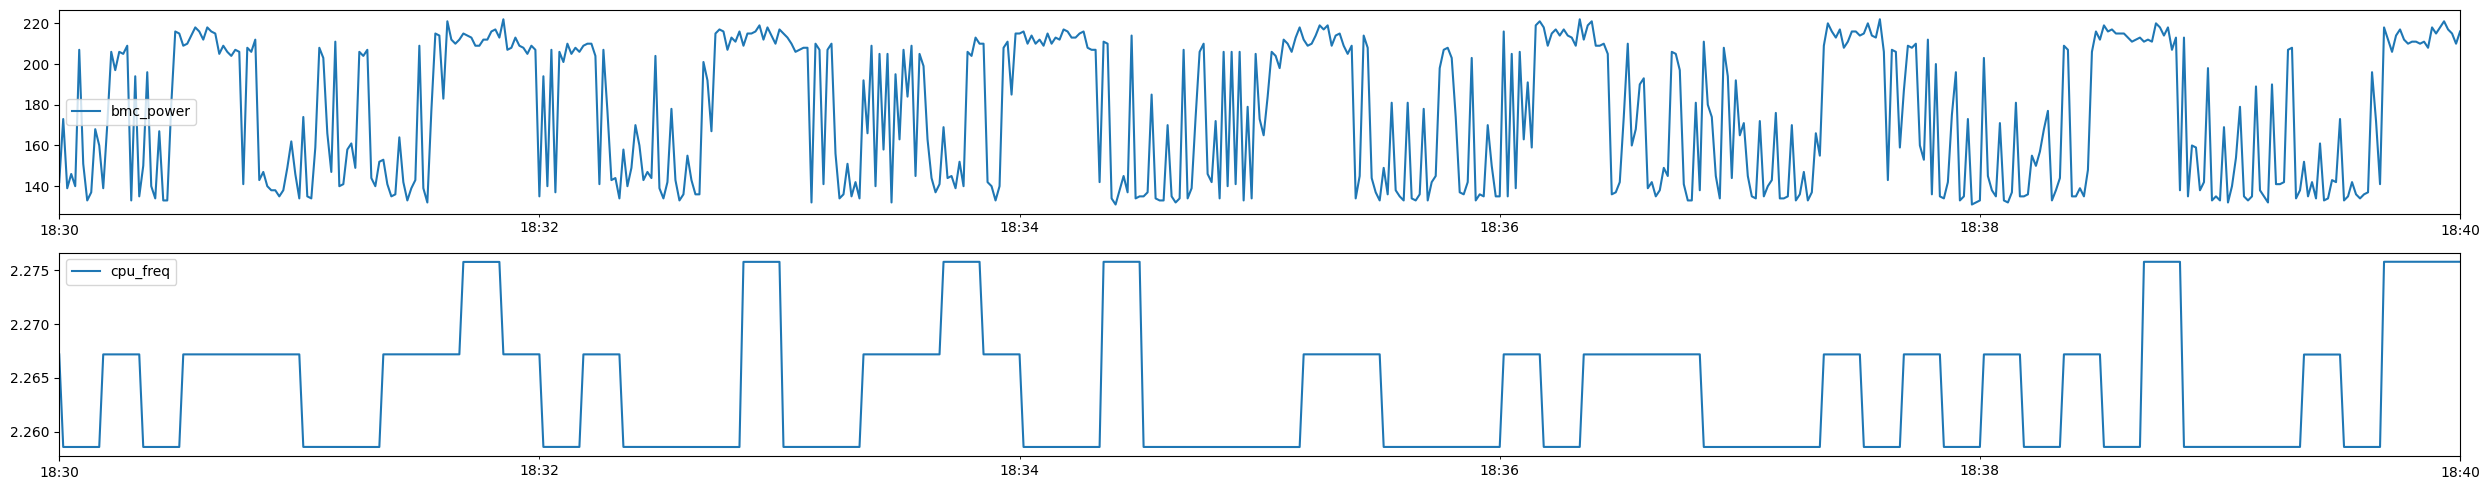

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

idle_start = datetime(year=2025, month=6, day=13, hour=18, minute=30, second=0)
delta = timedelta(minutes=10)
idle_end = idle_start + delta
# idle_end = datetime(year=2025, month=6, day=13, hour=21, minute=50, second=0)

idle_df = df[idle_start:idle_end]

idle_df = idle_df.resample("1s").mean()

idle_df.plot(y="bmc_power", ax=ax1)
idle_df.plot(y="cpu_freq", ax=ax2)

mean_idle = idle_df["bmc_power"].mean()
ax.axhline(mean_idle, color="red", linestyle="--")

ax.set_title(f"Idle power: {mean_idle:.2f} W")

fig.tight_layout()
plt.show()

## Load job information from files

In [81]:
base_dir = Path("/Volumes/pagessin/sync_root/projects/power_c100/outputs")
assert base_dir.exists()

In [153]:
all_runs = list(base_dir.glob("r*"))
all_runs

[PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r001'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r002'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r003'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r004'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r005'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r006'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r007'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r008'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r009'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r010'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r011'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r012'),
 PosixPath('/Volumes/pagessin/sync_root/projects/power_c100/outputs/r013'),
 PosixPath('

In [154]:
runs = []
starts = []
log_starts = []
ends = []
log_ends = []
durations = []
events = []
threads = []
procs = []

end_pattern = r"(\d{2}:\d{2}:\d{2}).*Joining Scheduler thread"
start_pattern = r"(\d{2}:\d{2}:\d{2}).*(?:Workers started processing events|AthenaHiveEventLoopMgr.*Starting loop on events)"

base_dt = datetime(year=2025, month=6, day=13, hour=0, minute=0, second=0)

for run in all_runs:
    print(run.name)
    log_file = run / "log.RAWtoALL"
    info_file = run / "info.json"
    assert info_file.exists()
    with info_file.open("r") as f:
        info = json.load(f)
    # print(info)
    runs.append(run.name)
    start_wall = info.get("start_wall", None)
    end_wall = info.get("end_wall", None)
    if start_wall is not None:
        start_wall = datetime.fromisoformat(start_wall)
    if end_wall is not None:
        end_wall = datetime.fromisoformat(end_wall)
    starts.append(start_wall)
    ends.append(end_wall)
    durations.append(info.get("wall_s", None))
    events.append(info.get("events", None))
    threads.append(info.get("threads", None))
    procs.append(info.get("procs", None))

    end_time = None
    start_time = None
    if log_file.exists():
        with open(log_file, "r") as f:
            for line in f:
                end_match = re.search(end_pattern, line)
                start_match = re.search(start_pattern, line)
                if end_match:
                    # print("END: ", end_match.group(0))
                    end_time_str = end_match.group(1)
                    hours, minutes, seconds = map(int, end_time_str.split(":"))
                    end_time = base_dt.replace(
                        hour=hours, minute=minutes, second=seconds
                    )
                if start_match:
                    assert start_time is None, "Multiple start matches"
                    # print("START: ", start_match.group(0))
                    start_time_str = start_match.group(1)
                    hours, minutes, seconds = map(int, start_time_str.split(":"))
                    start_time = base_dt.replace(
                        hour=hours, minute=minutes, second=seconds
                    )
        print("Time from log file: ", start_time, end_time)
        log_starts.append(start_time)
        log_ends.append(end_time)
    else:
        log_starts.append(float("nan"))
        log_ends.append(float("nan"))

    print()

run_df = pd.DataFrame(
    {
        "run": runs,
        "start": starts,
        "end": ends,
        "duration": durations,
        "log_start": log_starts,
        "log_end": log_ends,
        "events": events,
        "threads": threads,
        "procs": procs,
    }
)

run_df = run_df.sort_values(by="run")
run_df = run_df[4:]

r001
Time from log file:  None None

r002
Time from log file:  None None

r003
Time from log file:  2025-06-13 14:25:40 None

r004
Time from log file:  2025-06-13 14:51:19 None

r005
Time from log file:  2025-06-13 14:53:25 2025-06-13 14:56:26

r006
Time from log file:  2025-06-13 15:02:07 2025-06-13 15:39:55

r007
Time from log file:  2025-06-13 16:11:32 2025-06-13 16:23:41

r008
Time from log file:  2025-06-13 16:31:57 2025-06-13 16:37:58

r009
Time from log file:  2025-06-13 16:45:20 2025-06-13 16:56:47

r010
Time from log file:  2025-06-13 17:08:32 2025-06-13 17:14:27

r011
Time from log file:  2025-06-13 17:21:48 2025-06-13 17:32:31

r012
Time from log file:  2025-06-13 17:34:24 2025-06-13 17:45:06

r013
Time from log file:  2025-06-13 17:48:15 2025-06-13 17:59:55

r014
Time from log file:  2025-06-13 18:02:50 2025-06-13 18:13:44

r015
Time from log file:  2025-06-13 10:14:33 2025-06-13 10:44:52

r016

r017

r018

r019

r020

r021

r022

r023

r024

r025

r026

r027



In [155]:
# patch hostnames
hostnames = []
for run in run_df.itertuples():
    if run.start < datetime(year=2025, month=6, day=18):
        hostnames.append("ef-tb-g01")
    else:
        hostnames.append("pc-tbed-pub-41")
run_df["hostname"] = hostnames

run_df.columns

Index(['run', 'start', 'end', 'duration', 'log_start', 'log_end', 'events',
       'threads', 'procs', 'hostname'],
      dtype='object')

In [156]:
run_df["events"] = run_df["events"].astype(int)
run_df["procs"] = run_df["procs"].astype(int)
run_df["threads"] = run_df["threads"].astype(int)
run_df["cores"] = run_df["threads"] * run_df["procs"]
run_df["log_start"] = pd.to_datetime(run_df["log_start"])
run_df["log_end"] = pd.to_datetime(run_df["log_end"])
run_df["log_duration_s"] = (run_df["log_end"] - run_df["log_start"]).dt.total_seconds()
run_df["throughput_events_s"] = run_df["events"] / run_df["log_duration_s"]
run_df["event_duration_s"] = run_df["log_duration_s"] / run_df["events"]
run_df

,run,start,end,duration,log_start,log_end,events,threads,procs,hostname,cores,log_duration_s,throughput_events_s,event_duration_s
4,r005,2025-06-13 14:53:02.886817,2025-06-13 14:57:39.920870,277.034053,2025-06-13 14:53:25,2025-06-13 14:56:26,1000,4,4,ef-tb-g01,16,181.0,5.524862,0.181000
5,r006,2025-06-13 15:01:00.000000,2025-06-13 15:40:00.000000,0,2025-06-13 15:02:07,2025-06-13 15:39:55,50000,4,21,ef-tb-g01,84,2268.0,22.045855,0.045360
6,r007,2025-06-13 16:11:09.961649,2025-06-13 16:24:03.877131,773.915482,2025-06-13 16:11:32,2025-06-13 16:23:41,10000,4,10,ef-tb-g01,40,729.0,13.717421,0.072900
7,r008,2025-06-13 16:31:34.912215,2025-06-13 16:38:08.560737,393.648522,2025-06-13 16:31:57,2025-06-13 16:37:58,500,4,1,ef-tb-g01,4,361.0,1.385042,0.722000
8,r009,2025-06-13 16:44:58.454411,2025-06-13 16:56:52.921619,714.467208,2025-06-13 16:45:20,2025-06-13 16:56:47,15000,4,21,ef-tb-g01,84,687.0,21.834061,0.045800
9,r010,2025-06-13 17:08:10.645844,2025-06-13 17:14:34.344619,383.698775,2025-06-13 17:08:32,2025-06-13 17:14:27,1000,4,2,ef-tb-g01,8,355.0,2.816901,0.355000
10,r011,2025-06-13 17:21:26.602175,2025-06-13 17:32:50.044281,683.442106,2025-06-13 17:21:48,2025-06-13 17:32:31,15000,4,26,ef-tb-g01,104,643.0,23.328149,0.042867
11,r012,2025-06-13 17:34:02.524615,2025-06-13 17:45:24.961763,682.437148,2025-06-13 17:34:24,2025-06-13 17:45:06,15000,4,26,ef-tb-g01,104,642.0,23.364486,0.042800
12,r013,2025-06-13 17:47:52.577174,2025-06-13 18:00:16.709301,744.132127,2025-06-13 17:48:15,2025-06-13 17:59:55,17500,4,32,ef-tb-g01,128,700.0,25.000000,0.040000
13,r014,2025-06-13 18:02:27.374117,2025-06-13 18:14:05.851552,698.477435,2025-06-13 18:02:50,2025-06-13 18:13:44,17500,4,40,ef-tb-g01,160,654.0,26.758410,0.037371


In [157]:
%load_ext autoreload
%autoreload explicit
%aimport parse_run

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:

run_df["throughput_events_slope_s"] = np.zeros_like(run_df["throughput_events_s"])
run_df["slope_start"] = np.zeros_like(run_df["throughput_events_s"])
run_df["slope_end"] = np.zeros_like(run_df["throughput_events_s"])

parsed_runs = parse_run.parse_runs(all_runs[2:], n=len(all_runs[2:]))



  0%|          | 0/25 [00:00<?, ?it/s]

2025-06-13 14:25:41 2025-06-13 14:33:01
64 469 405
1.1505681818181819


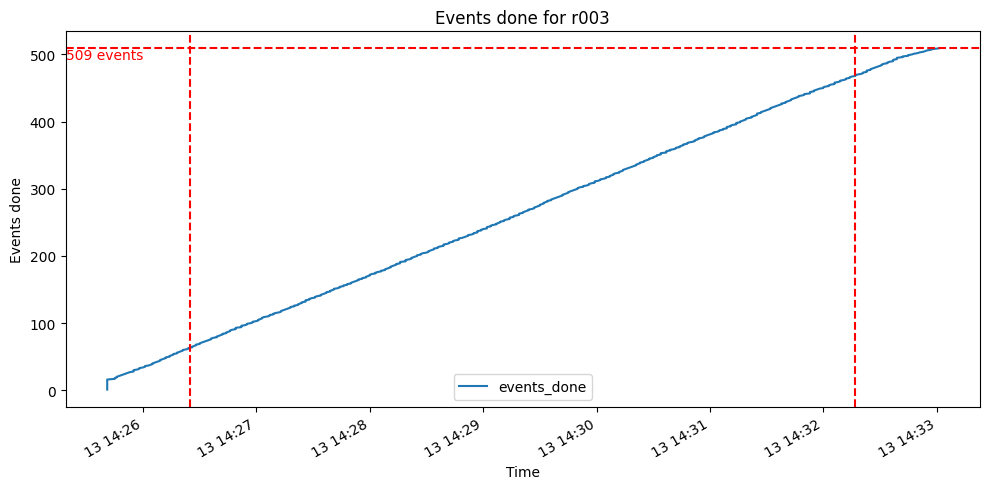

2025-06-13 14:51:19 2025-06-13 14:52:32
8 90 82
1.404109589041096


/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_85484/2232693755.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-06-13 14:26:25' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  run_df.loc[run_df.run == run.name, "slope_start"] = win_start
/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_85484/2232693755.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-06-13 14:32:17' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  run_df.loc[run_df.run == run.name, "slope_end"] = win_end


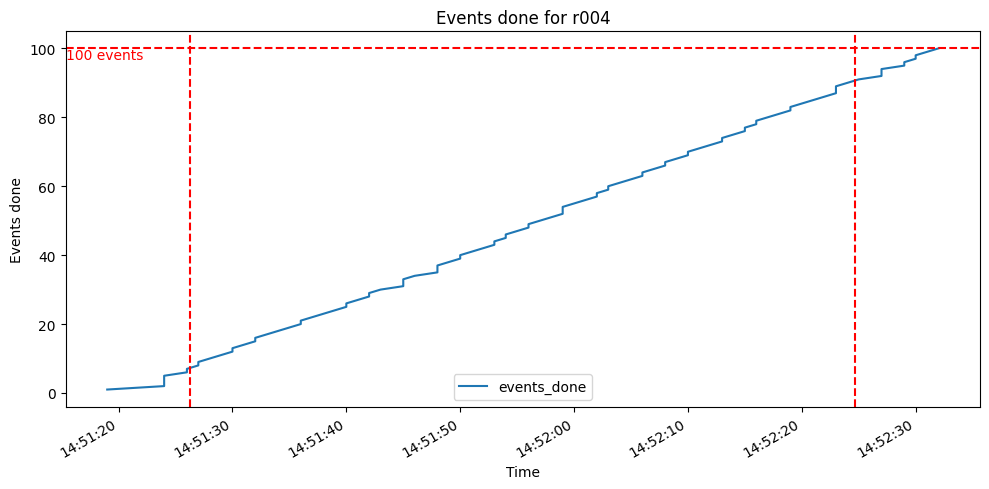

2025-06-13 14:53:26 2025-06-13 14:55:24
65 609 544
5.762711864406779


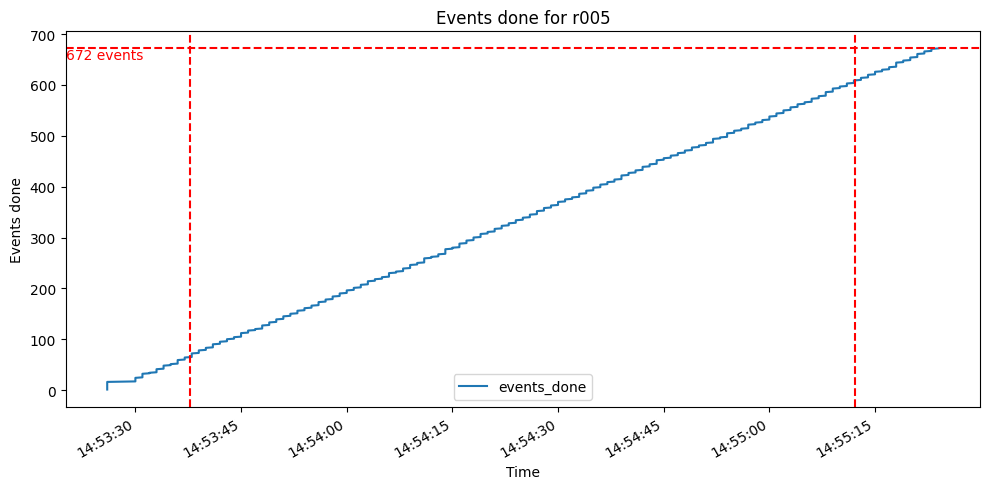

2025-06-13 15:02:09 2025-06-13 15:04:54
370 3284 2914
22.075757575757574


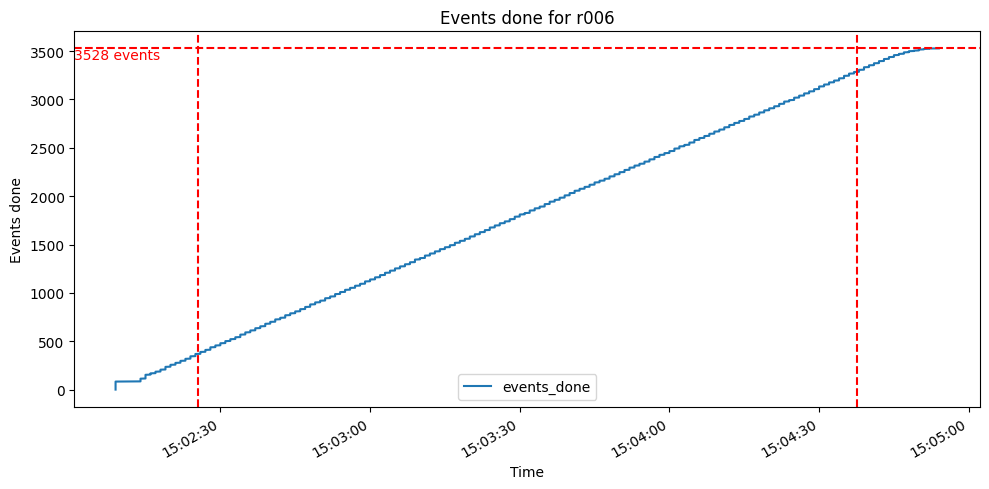

2025-06-13 16:11:33 2025-06-13 16:13:38
167 1551 1384
13.84


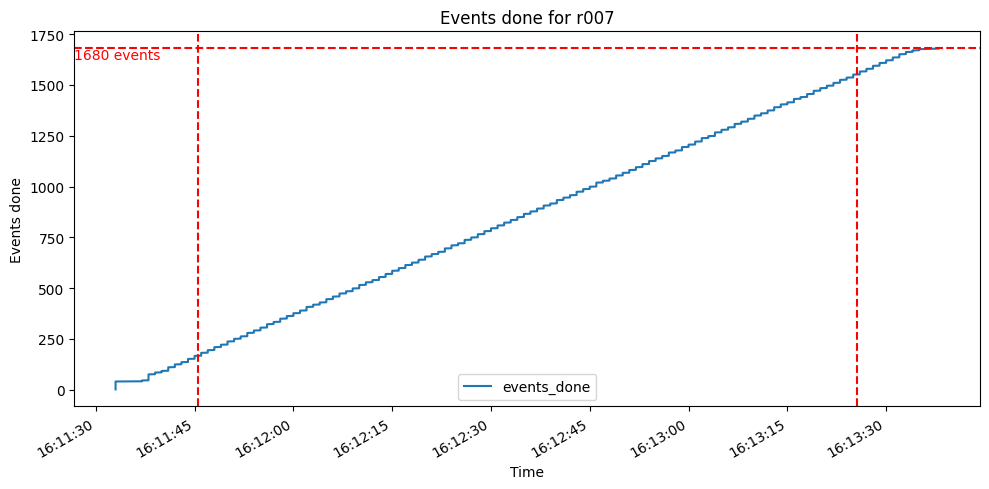

2025-06-13 16:31:57 2025-06-13 16:34:57
22 223 201
1.3958333333333333


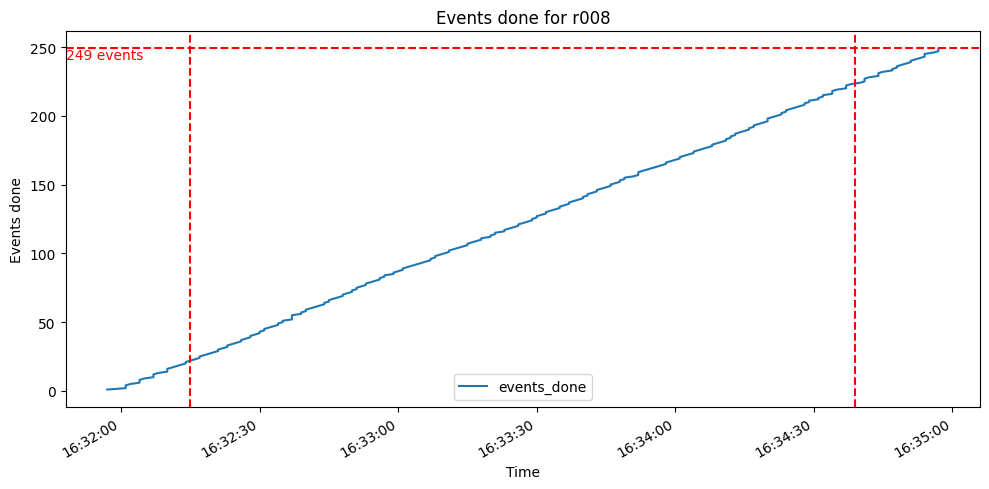

2025-06-13 16:45:22 2025-06-13 16:48:05
381 3273 2892
22.177914110429448


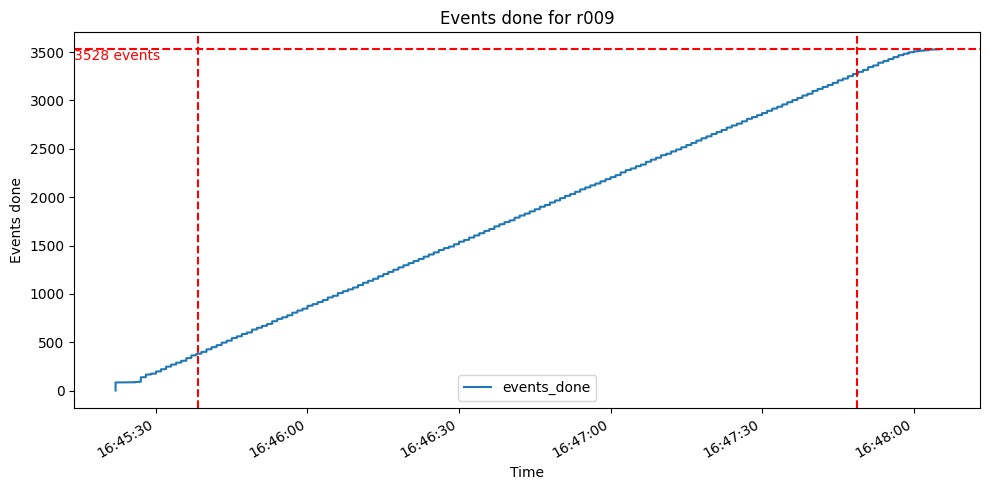

2025-06-13 17:08:33 2025-06-13 17:10:32
30 306 276
2.899159663865546


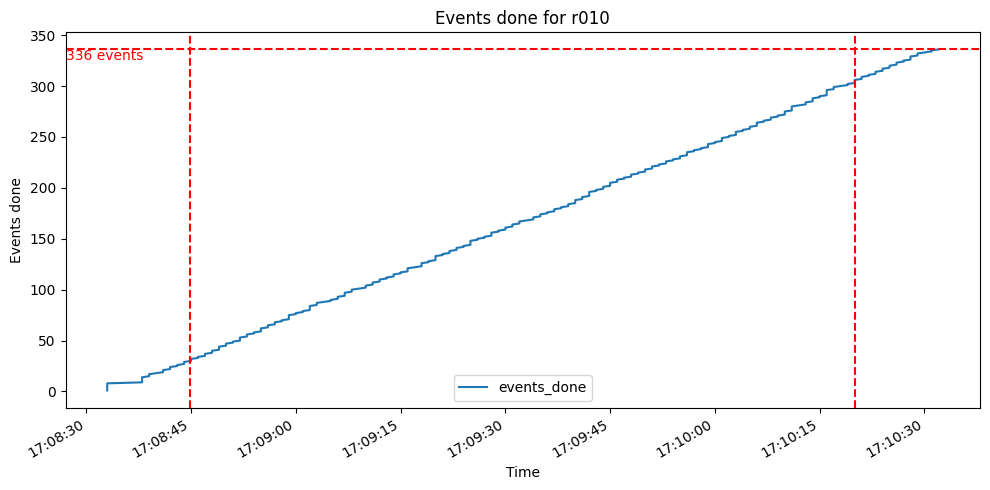

2025-06-13 17:21:50 2025-06-13 17:24:57
462 4054 3592
24.010695187165776


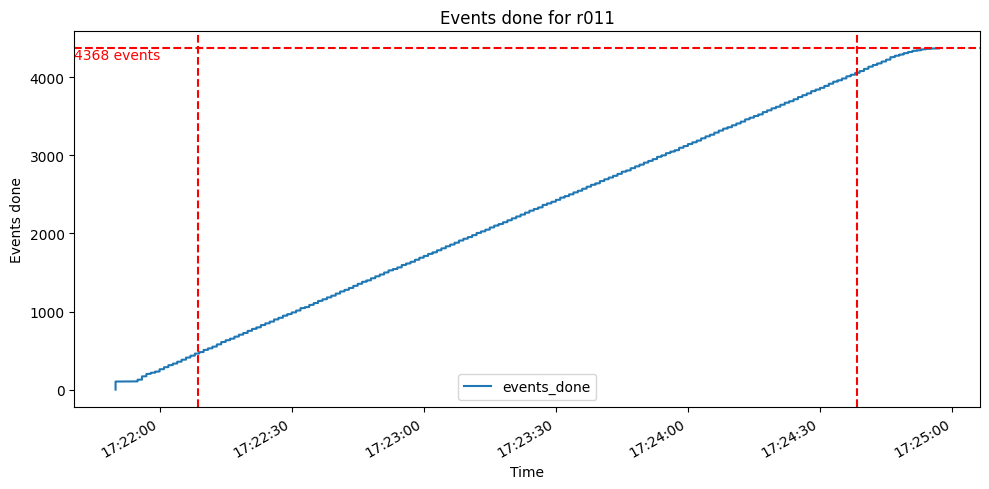

2025-06-13 17:34:26 2025-06-13 17:37:34
456 4081 3625
24.102393617021274


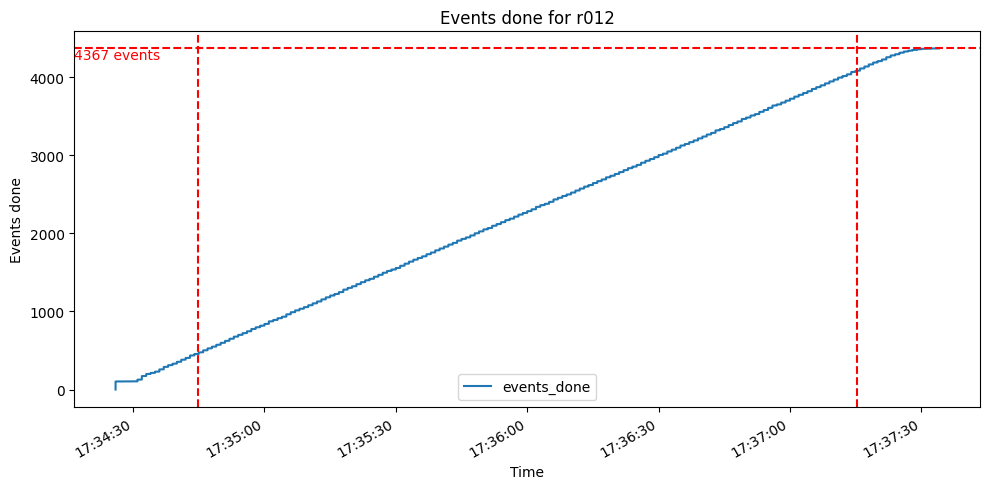

2025-06-13 17:48:16 2025-06-13 17:51:53
575 5049 4474
25.77188940092166


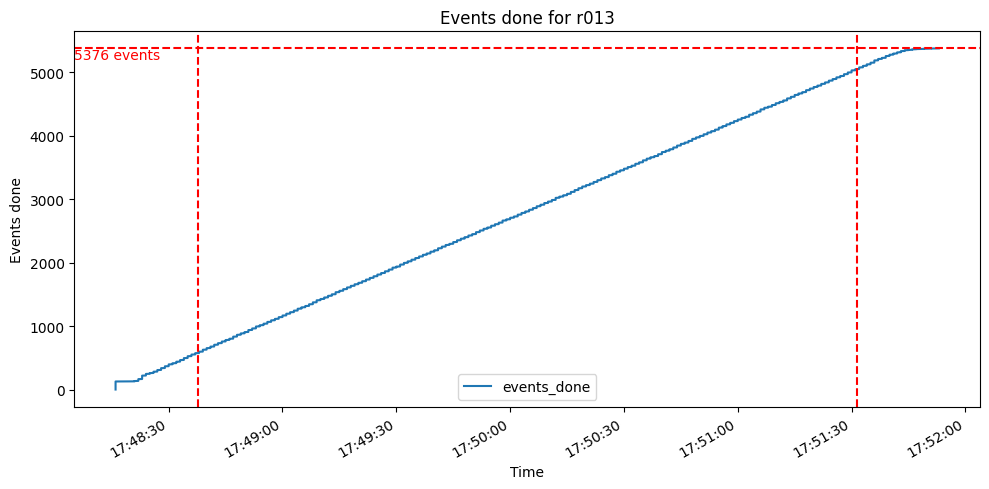

2025-06-13 18:02:51 2025-06-13 18:07:00
702 6258 5556
27.89156626506024


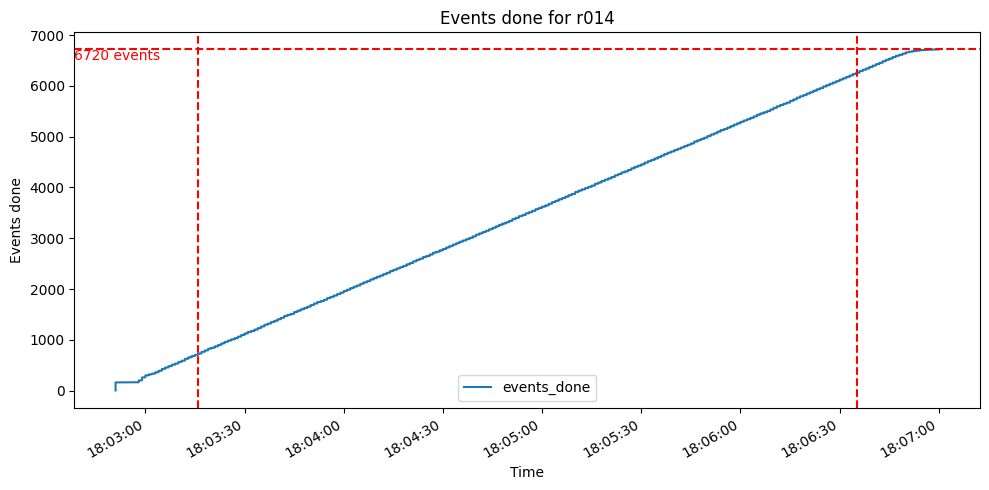

2025-06-17 10:14:33 2025-06-17 10:29:40
25 223 198
0.27287761852260195


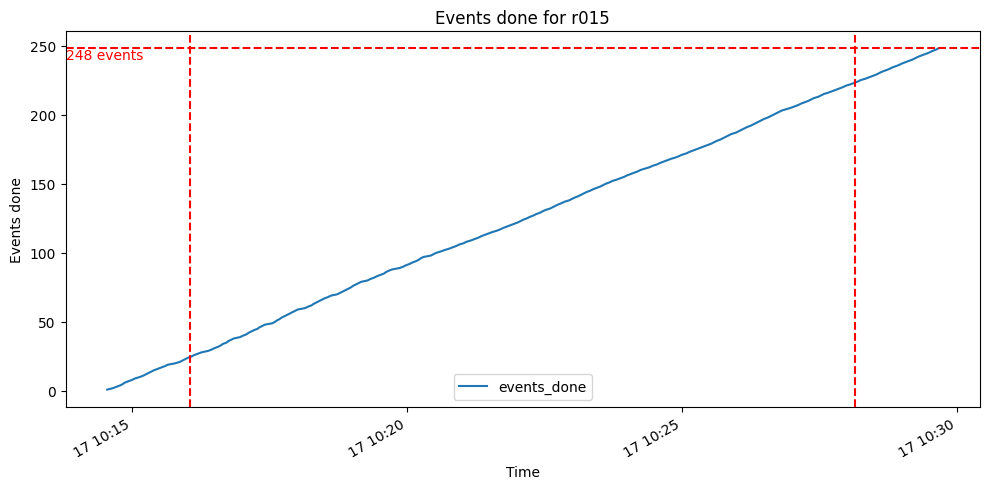

2025-06-17 11:39:53 2025-06-17 12:04:07
3982 37051 33069
28.42933287482806


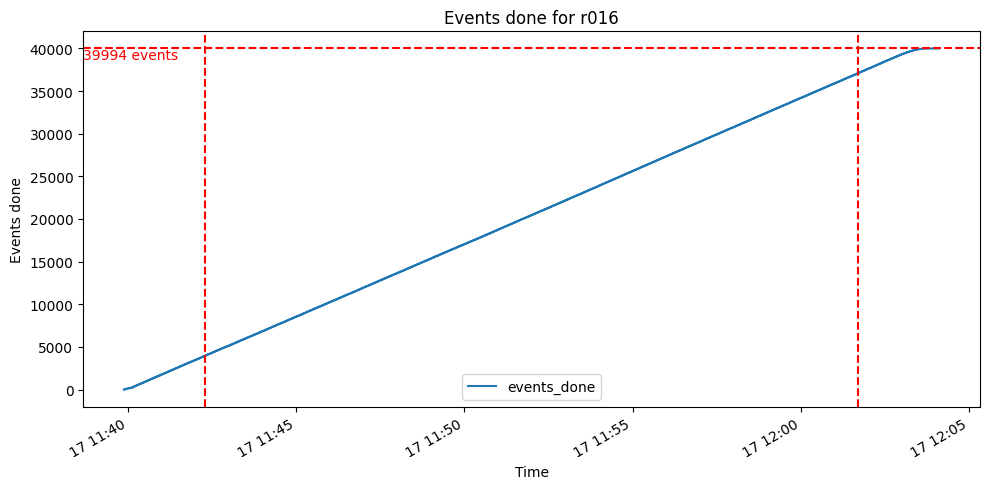

2025-06-17 12:59:33 2025-06-17 13:10:21
24 223 199
0.38387345679012347


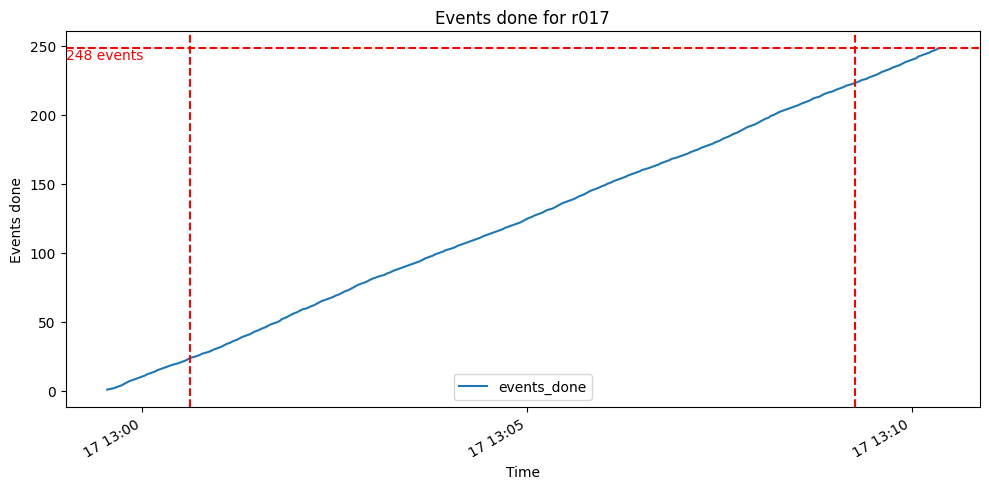

2025-06-20 14:12:32 2025-06-20 14:28:00
23 223 200
0.26939655172413796


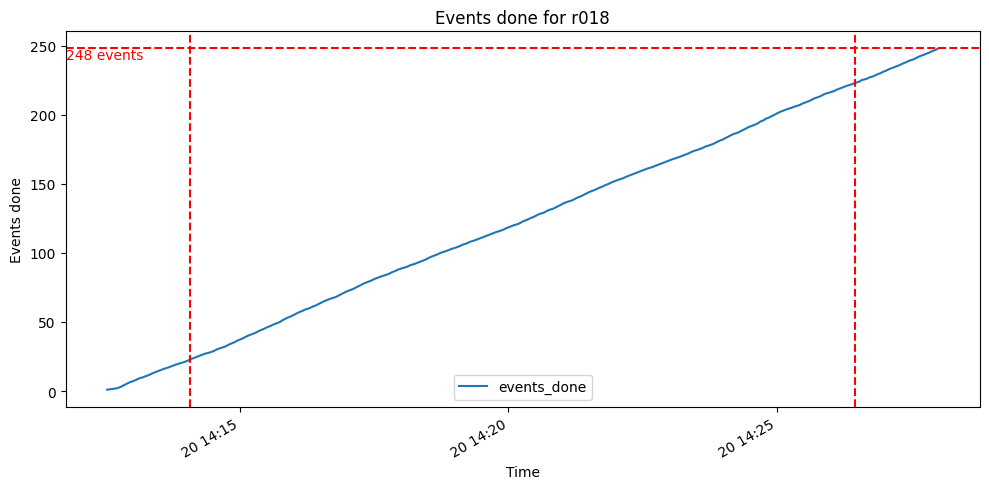

2025-06-20 14:47:39 2025-06-20 14:58:39
505 4946 4441
8.410984848484848


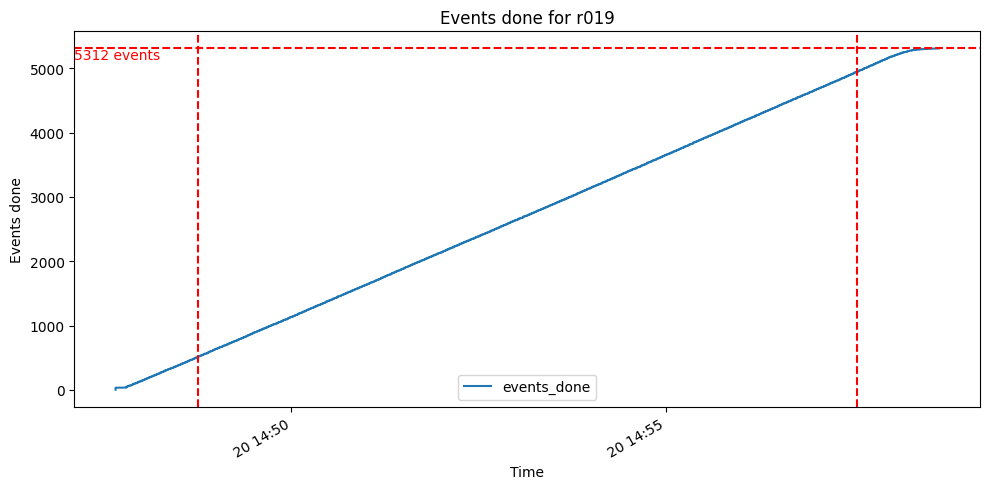

2025-06-23 10:03:15 2025-06-23 10:13:44
255 2456 2201
4.374006359300477


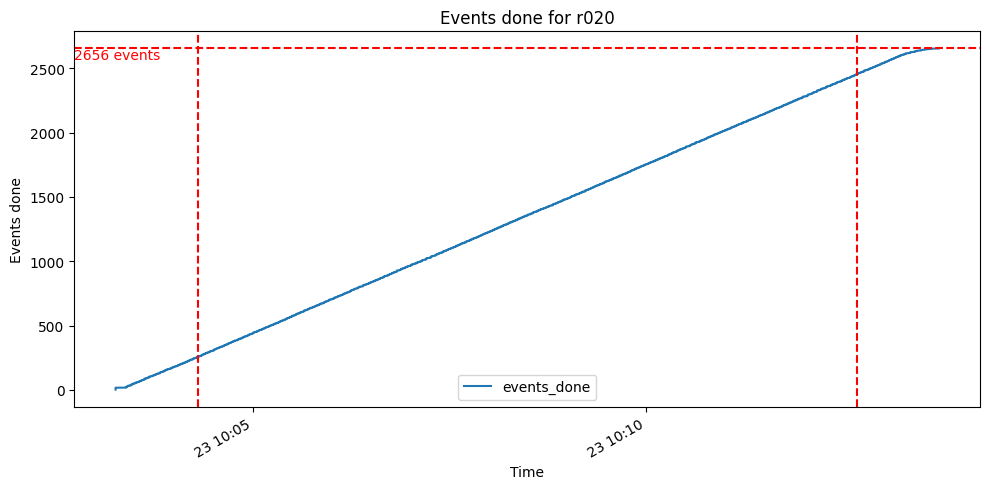

2025-06-23 10:26:42 2025-06-23 10:37:10
128 1227 1099
2.1875


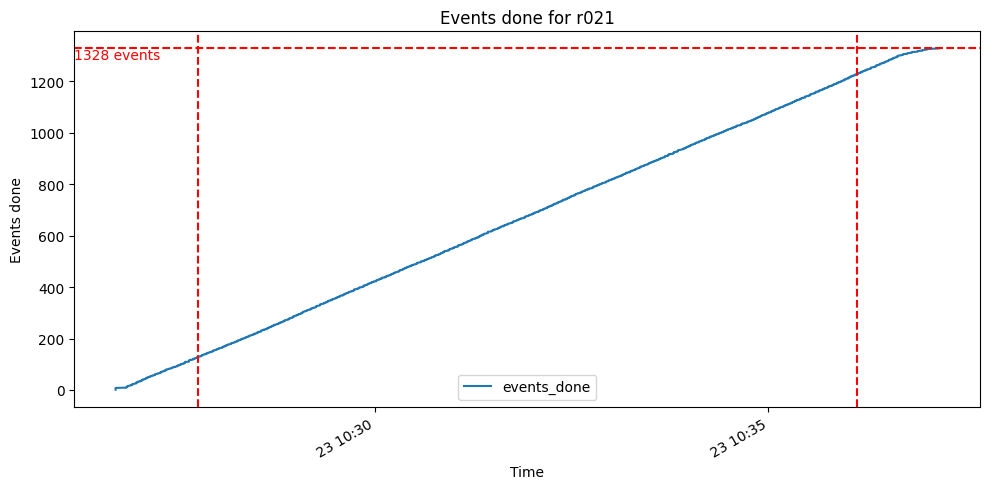

2025-06-23 10:49:29 2025-06-23 10:59:45
65 599 534
1.083603896103896


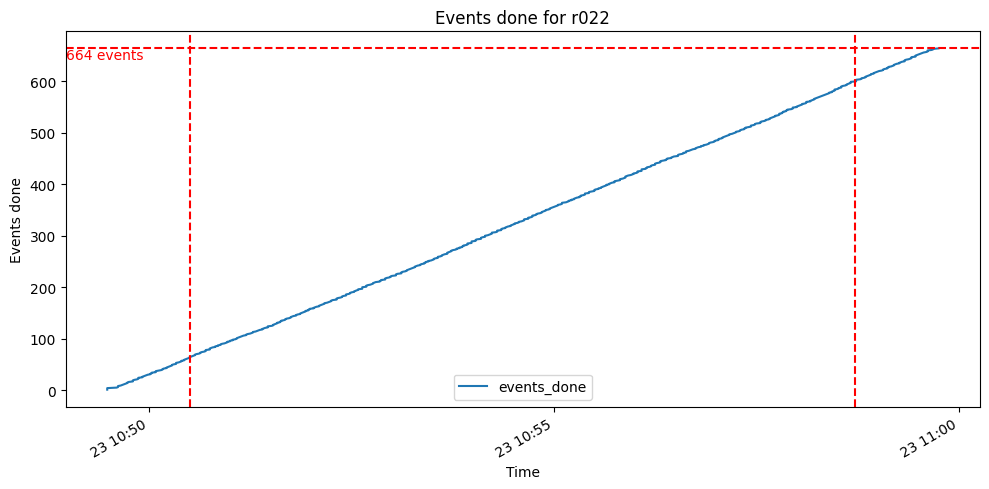

2025-06-23 11:13:05 2025-06-23 11:29:35
1058 9958 8900
11.237373737373737


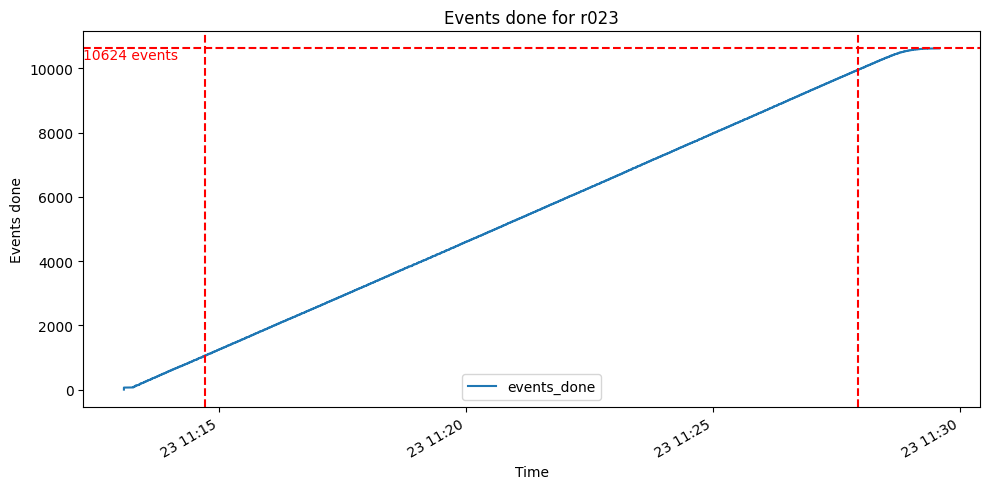

2025-06-23 13:46:37 2025-06-23 14:00:26
779 7450 6671
10.058805790108563


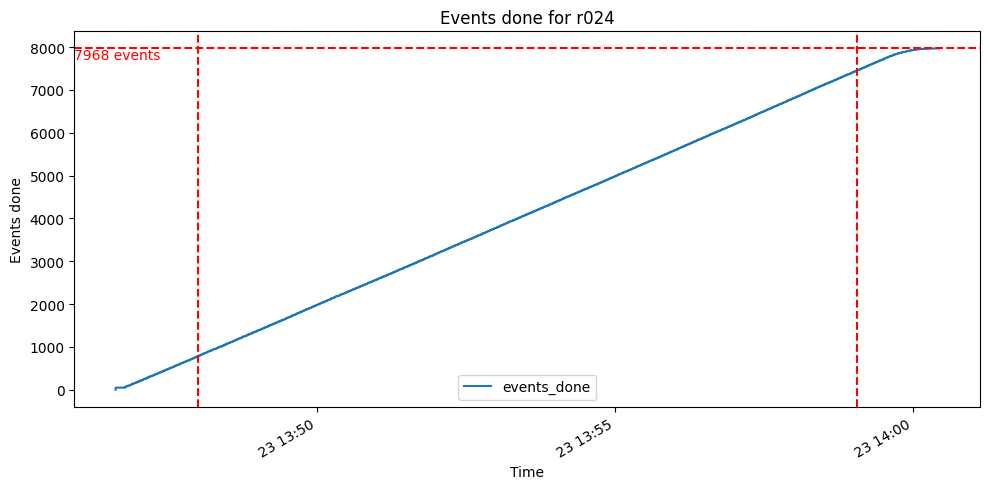

2025-06-23 14:50:43 2025-06-23 15:03:15
672 6219 5547
9.220412234042552


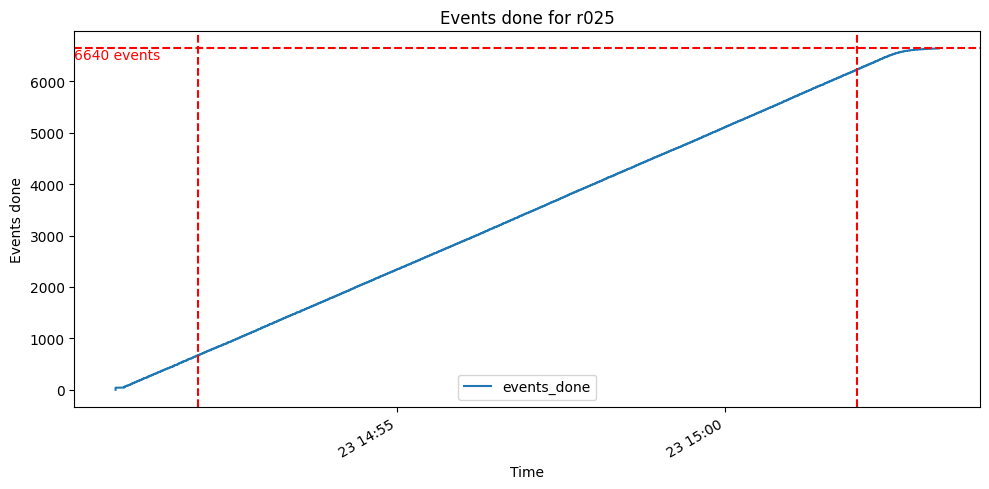

2025-06-23 15:15:25 2025-06-23 15:30:32
926 8660 7734
10.658765159867695


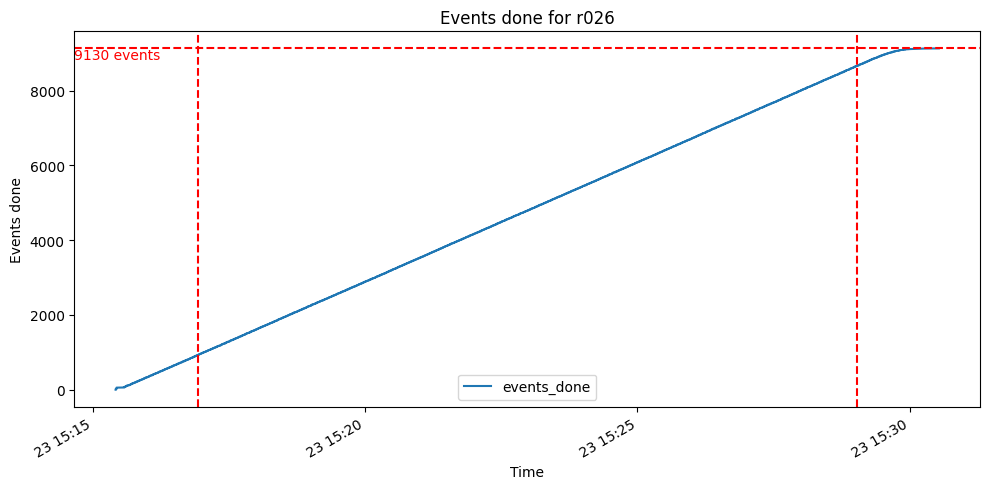

2025-06-23 15:34:48 2025-06-23 15:51:07
1065 9954 8889
11.349591419816138


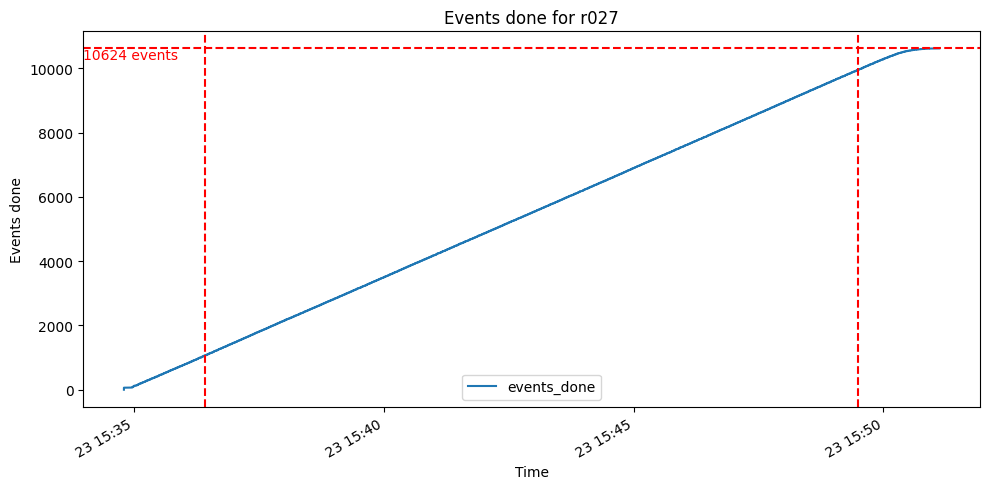

In [159]:
for run, events_df in parsed_runs:

    fig, ax = plt.subplots(figsize=(10, 5))
    events_df.plot(y="events_done", ax=ax)
    ax.axhline(events_df.iloc[-1]["events_done"], color="red", linestyle="--")
    ax.text(
        0,
        events_df.iloc[-1]["events_done"],
        f"{events_df.iloc[-1]['events_done']} events",
        color="red",
        ha="left",
        va="top",
        transform=ax.get_yaxis_transform(),
    )
    ax.set_ylabel("Events done")
    ax.set_xlabel("Time")
    ax.set_title(f"Events done for {run.name}")

    total_range = events_df.index[-1] - events_df.index[0]
    win_start = events_df.index[0] + total_range * 0.1
    win_end = events_df.index[-1] - total_range * 0.1

    # win_start = events_df.index[0] + timedelta(seconds=30)
    # win_end = events_df.index[-1] - timedelta(seconds=20)

    log_start = events_df.index[0]
    log_end = events_df.index[-1]

    print(log_start, log_end)

    win_width = (win_end - win_start).total_seconds()
    events_start = events_df[win_start:win_end].iloc[0]["events_done"]
    events_end = events_df[win_start:win_end].iloc[-1]["events_done"]

    print(events_start, events_end, events_end - events_start)

    throughput = (events_end - events_start) / win_width
    print(throughput)

    ax.axvline(win_start, color="red", linestyle="--")
    ax.axvline(win_end, color="red", linestyle="--")

    out = Path.cwd() / "throughput"
    out.mkdir(exist_ok=True)
    fig.tight_layout()
    fig.savefig(out / f"throughput_{run.name}.pdf")
    fig.savefig(out / f"throughput_{run.name}.png", dpi=300)

    plt.show()

    run_df.loc[run_df.run == run.name, "throughput_events_slope_s"] = throughput
    run_df.loc[run_df.run == run.name, "slope_start"] = win_start
    run_df.loc[run_df.run == run.name, "slope_end"] = win_end

In [160]:
run_df

,run,start,end,duration,log_start,log_end,events,threads,procs,hostname,cores,log_duration_s,throughput_events_s,event_duration_s,throughput_events_slope_s,slope_start,slope_end
4,r005,2025-06-13 14:53:02.886817,2025-06-13 14:57:39.920870,277.034053,2025-06-13 14:53:25,2025-06-13 14:56:26,1000,4,4,ef-tb-g01,16,181.0,5.524862,0.181000,5.762712,2025-06-13 14:53:37.800000,2025-06-13 14:55:12.200000
5,r006,2025-06-13 15:01:00.000000,2025-06-13 15:40:00.000000,0,2025-06-13 15:02:07,2025-06-13 15:39:55,50000,4,21,ef-tb-g01,84,2268.0,22.045855,0.045360,22.075758,2025-06-13 15:02:25.500000,2025-06-13 15:04:37.500000
6,r007,2025-06-13 16:11:09.961649,2025-06-13 16:24:03.877131,773.915482,2025-06-13 16:11:32,2025-06-13 16:23:41,10000,4,10,ef-tb-g01,40,729.0,13.717421,0.072900,13.840000,2025-06-13 16:11:45.500000,2025-06-13 16:13:25.500000
7,r008,2025-06-13 16:31:34.912215,2025-06-13 16:38:08.560737,393.648522,2025-06-13 16:31:57,2025-06-13 16:37:58,500,4,1,ef-tb-g01,4,361.0,1.385042,0.722000,1.395833,2025-06-13 16:32:15,2025-06-13 16:34:39
8,r009,2025-06-13 16:44:58.454411,2025-06-13 16:56:52.921619,714.467208,2025-06-13 16:45:20,2025-06-13 16:56:47,15000,4,21,ef-tb-g01,84,687.0,21.834061,0.045800,22.177914,2025-06-13 16:45:38.300000,2025-06-13 16:47:48.700000
9,r010,2025-06-13 17:08:10.645844,2025-06-13 17:14:34.344619,383.698775,2025-06-13 17:08:32,2025-06-13 17:14:27,1000,4,2,ef-tb-g01,8,355.0,2.816901,0.355000,2.899160,2025-06-13 17:08:44.900000,2025-06-13 17:10:20.100000
10,r011,2025-06-13 17:21:26.602175,2025-06-13 17:32:50.044281,683.442106,2025-06-13 17:21:48,2025-06-13 17:32:31,15000,4,26,ef-tb-g01,104,643.0,23.328149,0.042867,24.010695,2025-06-13 17:22:08.700000,2025-06-13 17:24:38.300000
11,r012,2025-06-13 17:34:02.524615,2025-06-13 17:45:24.961763,682.437148,2025-06-13 17:34:24,2025-06-13 17:45:06,15000,4,26,ef-tb-g01,104,642.0,23.364486,0.042800,24.102394,2025-06-13 17:34:44.800000,2025-06-13 17:37:15.200000
12,r013,2025-06-13 17:47:52.577174,2025-06-13 18:00:16.709301,744.132127,2025-06-13 17:48:15,2025-06-13 17:59:55,17500,4,32,ef-tb-g01,128,700.0,25.000000,0.040000,25.771889,2025-06-13 17:48:37.700000,2025-06-13 17:51:31.300000
13,r014,2025-06-13 18:02:27.374117,2025-06-13 18:14:05.851552,698.477435,2025-06-13 18:02:50,2025-06-13 18:13:44,17500,4,40,ef-tb-g01,160,654.0,26.758410,0.037371,27.891566,2025-06-13 18:03:15.900000,2025-06-13 18:06:35.100000


/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_85484/1802145628.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha="center", va="top")
/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_85484/1802145628.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha="center", va="top")
/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_85484/1802145628.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha="center", va="top")
/var/folders/25/4_8mtscd76z0dyl6_414z67m0000gn/T/ipykernel_85484/1802145628.py:21: UserWarning: set_ticklabels() should only be us

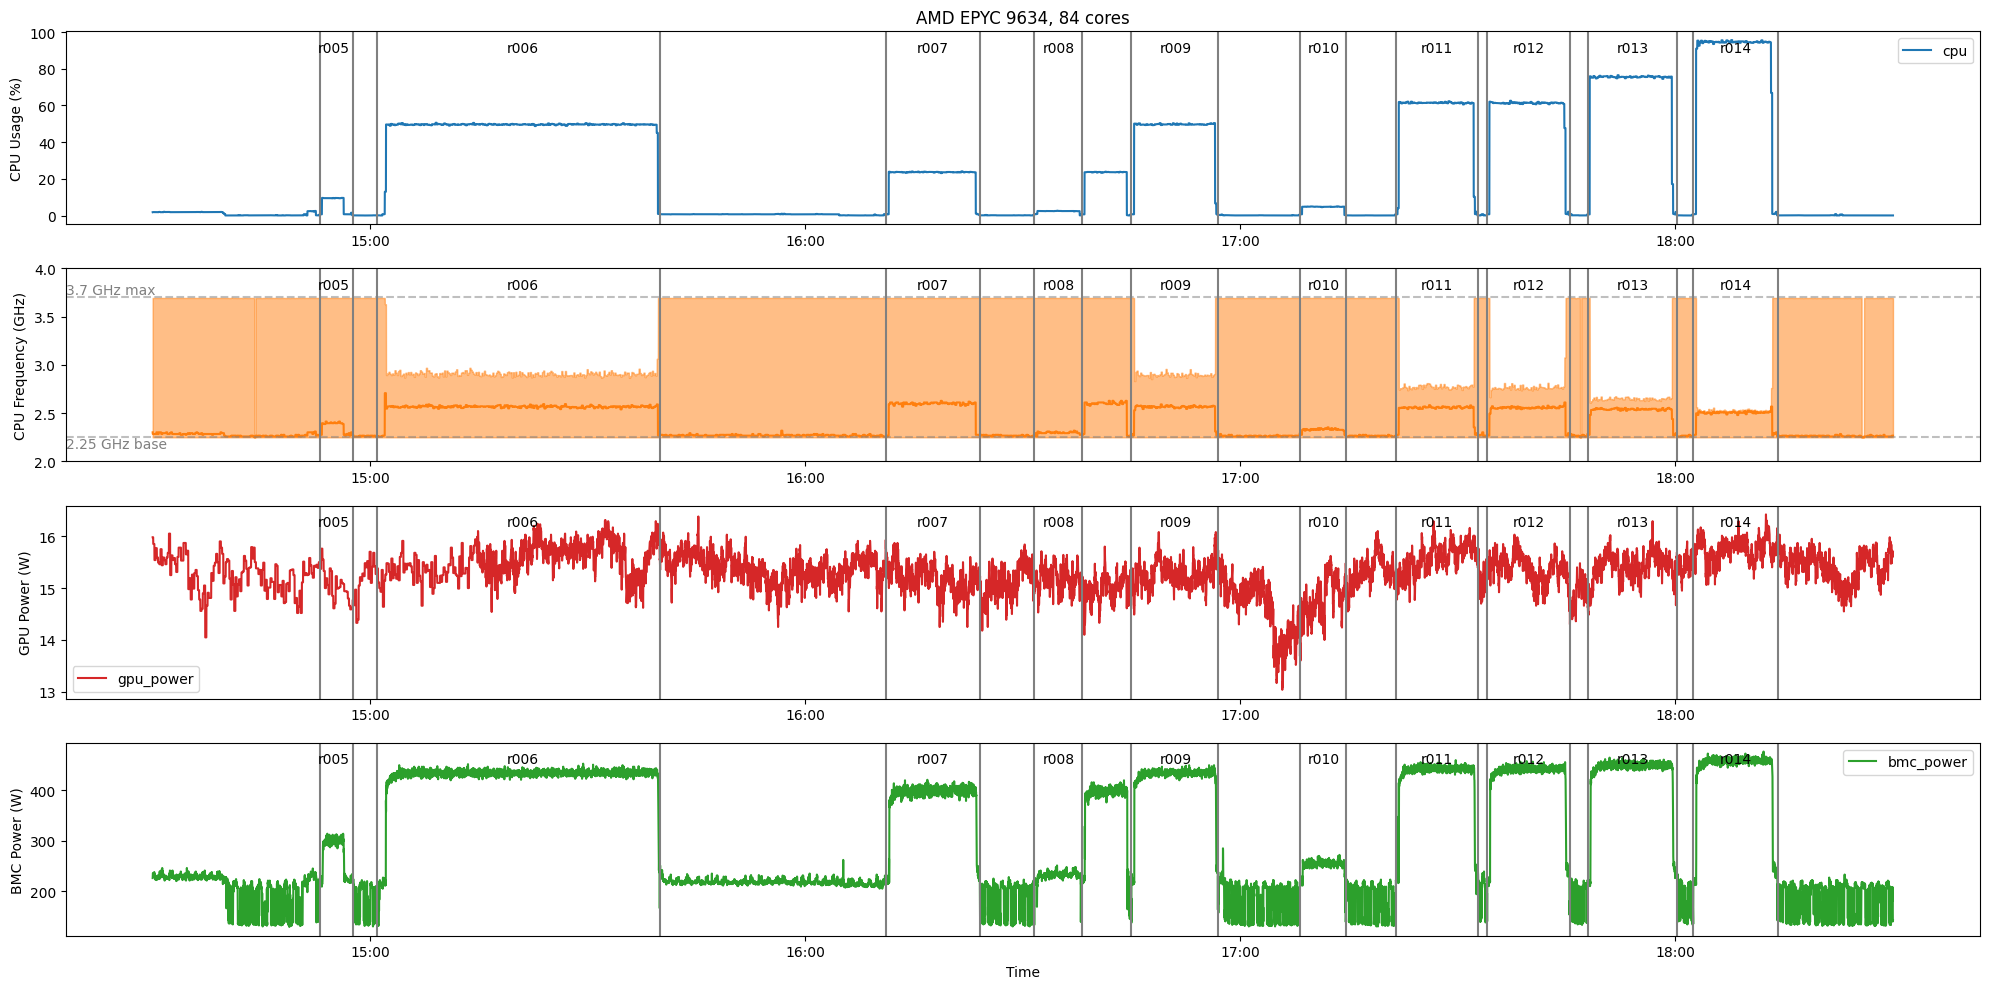

In [161]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))

start_date = datetime(2025, 6, 13, 14, 30, 0)
end_date = datetime(2025, 6, 13, 18, 30, 0)
pdf = df[start_date:end_date]

pdf.plot(y="cpu", ax=ax1)
pdf.plot(y="gpu_power", ax=ax3, color="tab:red")
pdf.plot(y="bmc_power", ax=ax4, color="tab:green")

# df.plot(y="cpu_freq", ax=ax2, color="tab:orange", label="CPU Frequency (GHz)")
ax2.fill_between(
    pdf.index, pdf["cpu_freq_max"], pdf["cpu_freq_min"], color="tab:orange", alpha=0.5
)
ax2.plot(pdf.index, pdf["cpu_freq"], color="tab:orange")
ax2.set_ylim(2.0, 4.0)

apply_date_format(ax1, ax2, ax3, ax4)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha="center", va="top")


ax1.set_ylabel("CPU Usage (%)")
ax2.set_ylabel("CPU Frequency (GHz)")
ax3.set_ylabel("GPU Power (W)")
ax4.set_ylabel("BMC Power (W)")

ax4.set_xlabel("Time")

# ax2.axhline()

ax1.set_title("AMD EPYC 9634, 84 cores")

ax2.axhline(3.7, color="gray", linestyle="--", alpha=0.5)
ax2.axhline(2.25, color="gray", linestyle="--", alpha=0.5)
ax2.text(
    0,
    2.25,
    "2.25 GHz base",
    color="gray",
    ha="left",
    va="top",
    transform=ax2.get_yaxis_transform(),
)
ax2.text(
    0,
    3.7,
    "3.7 GHz max",
    color="gray",
    ha="left",
    va="bottom",
    transform=ax2.get_yaxis_transform(),
)

for run in run_df.itertuples():
    if run.start < start_date or run.end > end_date:
        continue
    pos = run.log_start + (run.log_end - run.log_start) / 2
    for ax in (ax1, ax2, ax3, ax4):
        ymin, ymax = ax.get_ylim()
        ypos = ymax - (ymax - ymin) * 0.05
        ax.axvline(run.start, color="gray")
        ax.axvline(run.end, color="gray")
        ax.text(pos, ypos, run.run, va="top", ha="center")

fig.tight_layout()
fig.savefig("power.pdf")
fig.savefig("power.png", dpi=300)
plt.show()

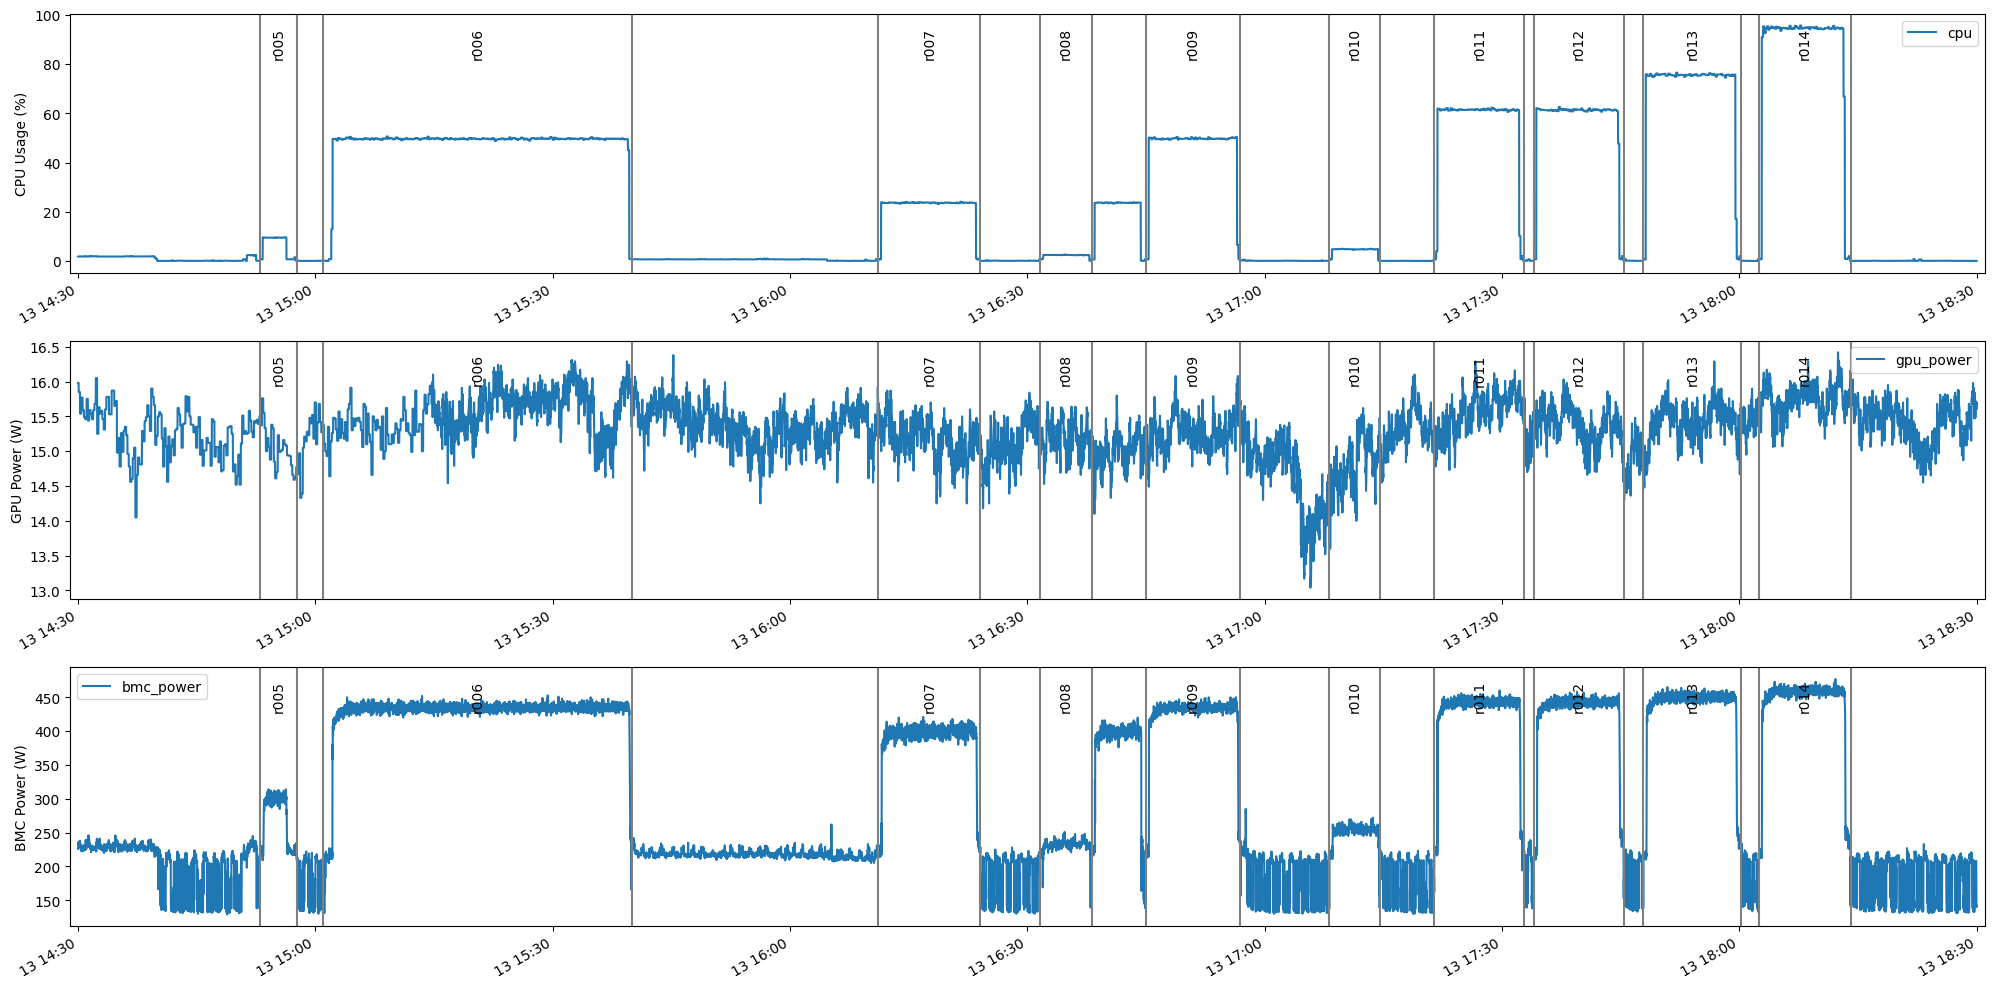

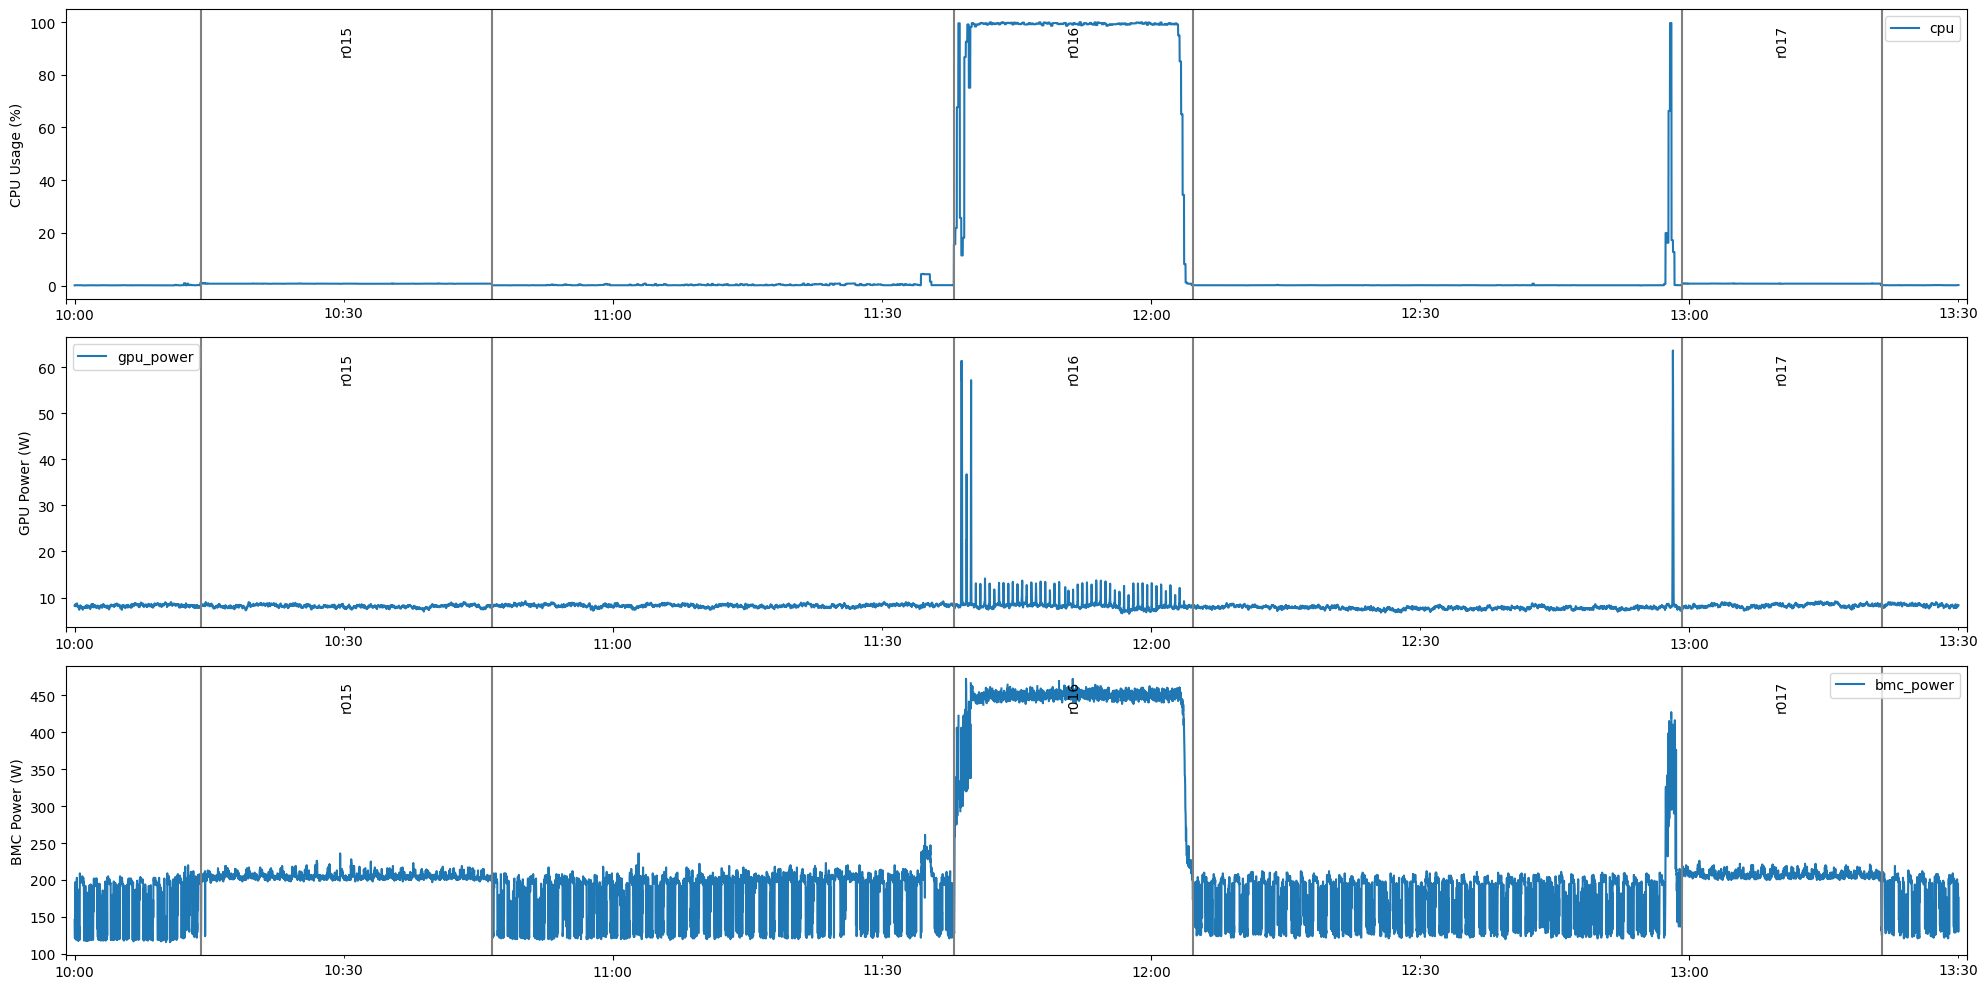

In [162]:
windows = [
    (datetime(2025, 6, 13, 14, 30, 0), datetime(2025, 6, 13, 18, 30, 0)),
    (datetime(2025, 6, 17, 10, 0, 0), datetime(2025, 6, 17, 13, 30, 0)),
]

for start, end in windows:
    wdf = df[start:end]
    # print(wdf)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
    wdf.plot(y="cpu", ax=ax1)
    wdf.plot(y="gpu_power", ax=ax2)
    wdf.plot(y="bmc_power", ax=ax3)

    # apply_date_format(ax1, ax2, ax3)

    ax1.set_ylabel("CPU Usage (%)")
    ax2.set_ylabel("GPU Power (W)")
    ax3.set_ylabel("BMC Power (W)")

    time_padding = pd.Timedelta(seconds=60)
    for ax in (ax1, ax2, ax3):
        ax.set_xlim(start - time_padding, end + time_padding)

    for run in run_df.itertuples():
        if run.start < start or run.end > end:
            continue
        pos = run.start + (run.end - run.start) / 2
        for ax in (ax1, ax2, ax3):
            ymin, ymax = ax.get_ylim()
            ypos = ymax - (ymax - ymin) * 0.05
            ax.axvline(run.start, color="gray")
            ax.axvline(run.end, color="gray")
            ax.text(pos, ypos, run.run, va="top", ha="center", rotation=90)

    fig.tight_layout()
    fig.savefig("power_with_runs.pdf")
    fig.savefig("power_with_runs.png", dpi=300)
    plt.show()

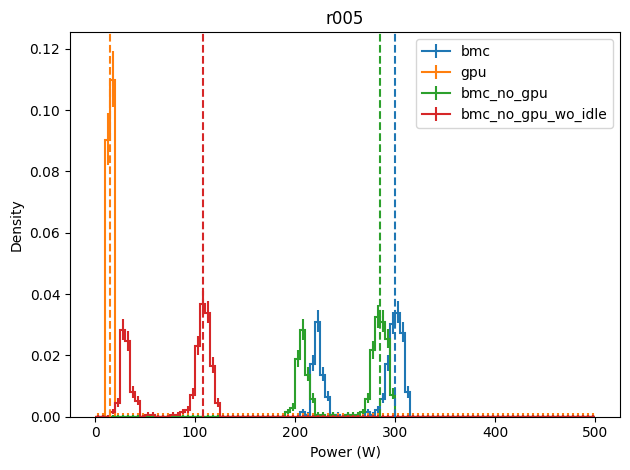

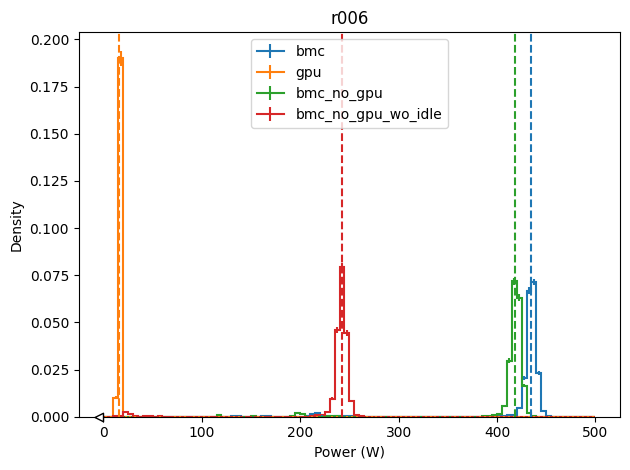

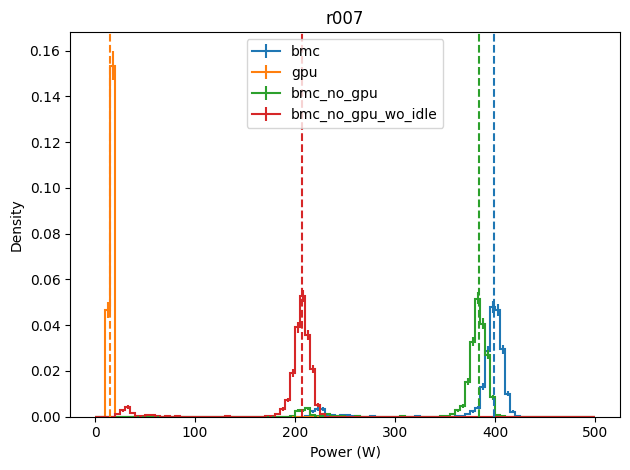

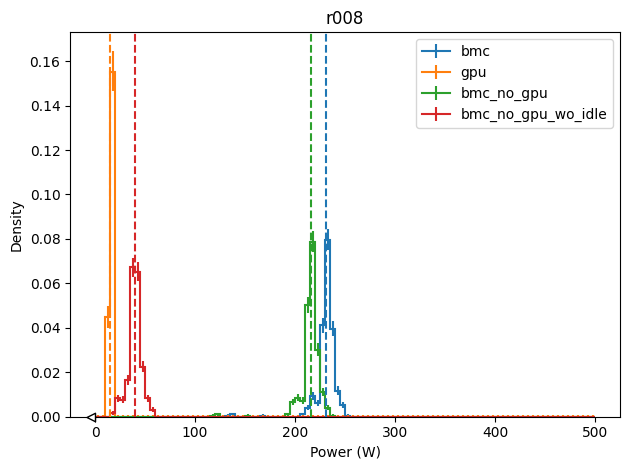

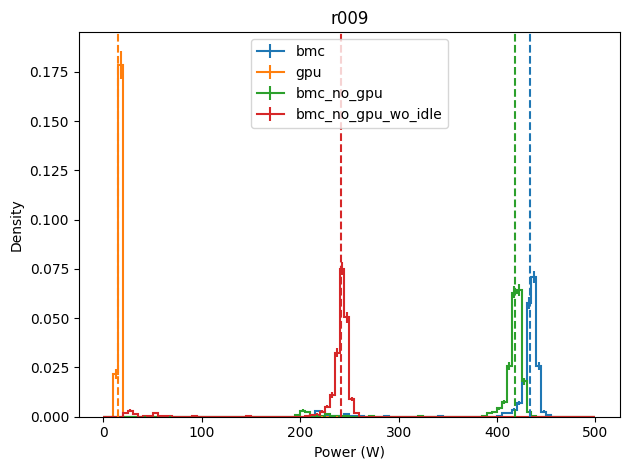

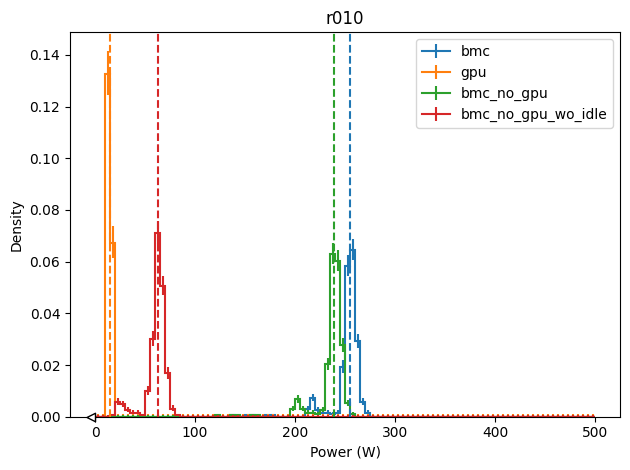

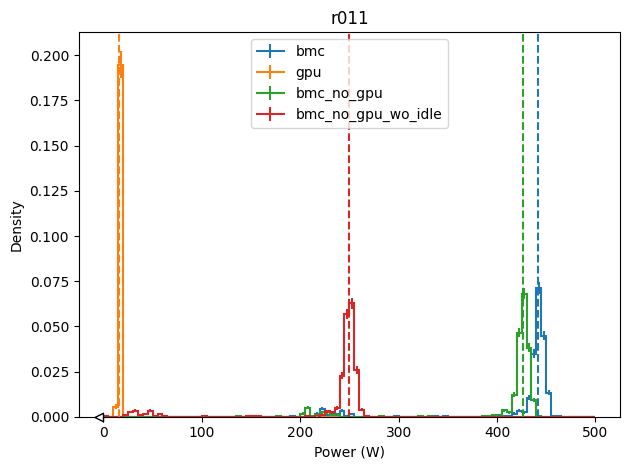

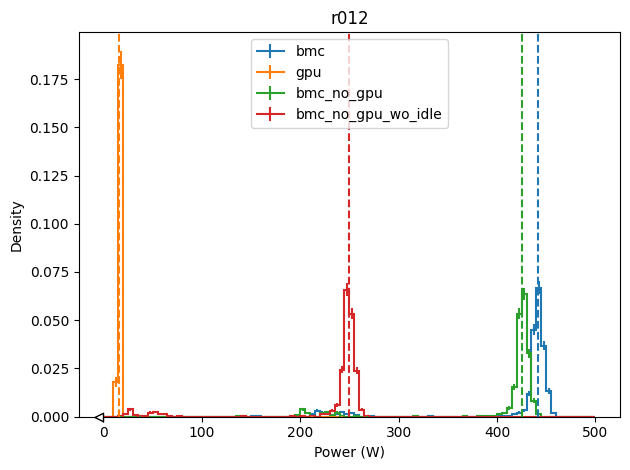

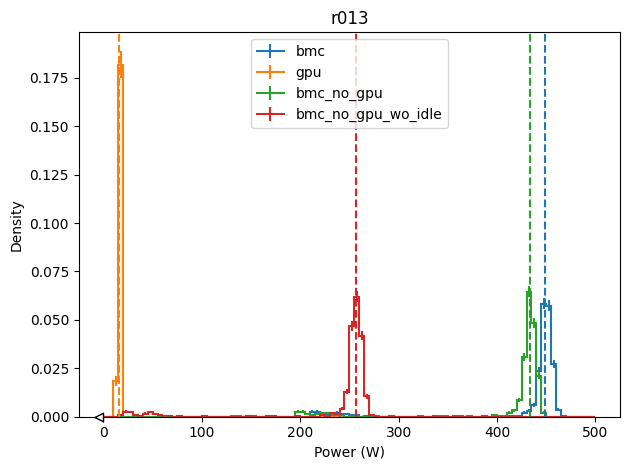

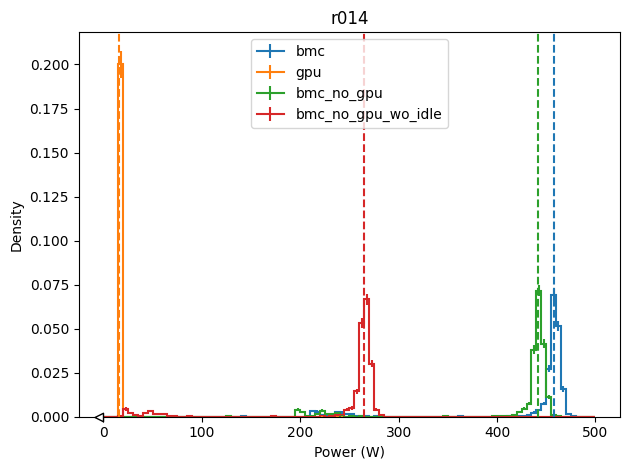

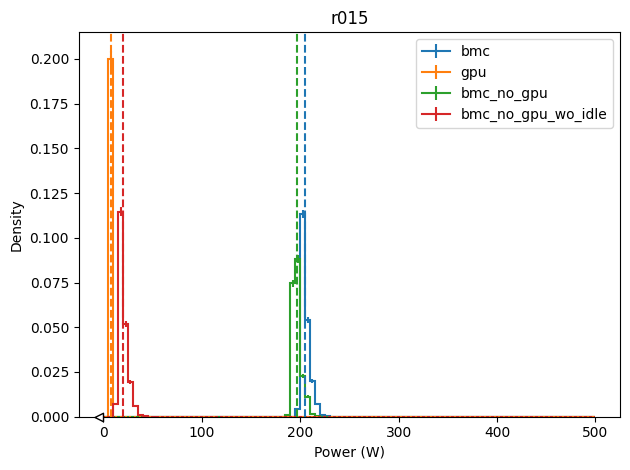

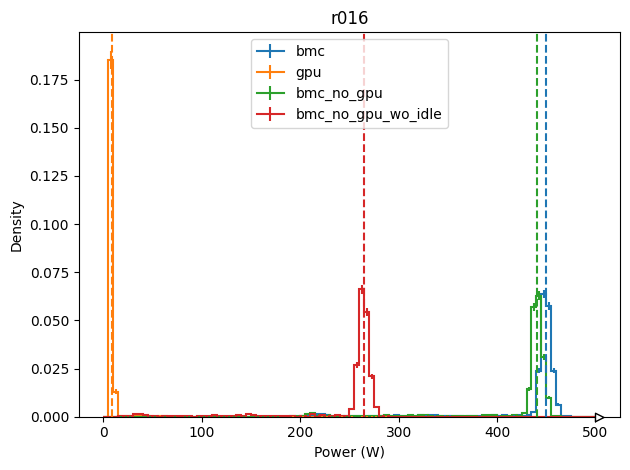

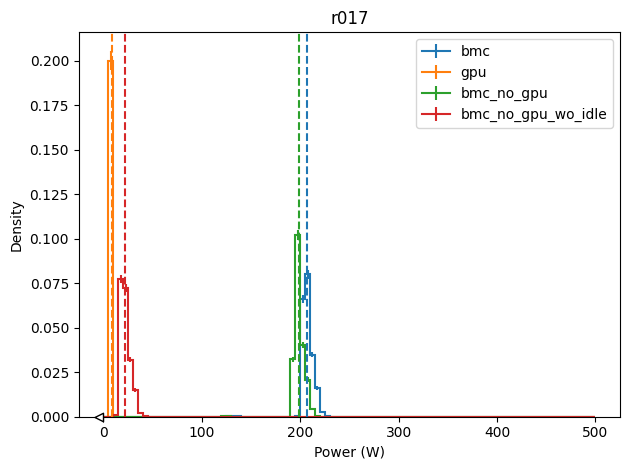

In [163]:
bmc_power_medians = []
gpu_power_medians = []
bmc_no_gpu_medians = []
bmc_no_gpu_wo_idle_medians = []

def find_peak(values):
    # mode = scipy.stats.mode(values)
    # print(mode)
    h, edges = np.histogram(values, bins=100, range=(0, 500))
    peak = edges[h.argmax()]


    window = values[np.abs(values - peak) < 30]
    return window.mean()


for run in run_df.itertuples():
    if run.hostname != "ef-tb-g01": 
        bmc_power_medians.append(None)
        gpu_power_medians.append(None)
        bmc_no_gpu_medians.append(None)
        bmc_no_gpu_wo_idle_medians.append(None)
        continue
    # if run.run != "r015": continue
    meas_df = df[run.start : run.end]
    bmc_power_median = find_peak(meas_df["bmc_power"])
    gpu_power_median = find_peak(meas_df["gpu_power"])
    bmc_power_medians.append(bmc_power_median)
    gpu_power_medians.append(gpu_power_median)

    h = hist.Hist(
        hist.axis.Regular(100, 0, 500, name="power"),
        hist.axis.StrCategory(
            ["bmc", "gpu", "bmc_no_gpu", "bmc_no_gpu_wo_idle"], name="source"
        ),
    )

    bmc = meas_df["bmc_power"]
    bmc_wo_idle = bmc - mean_idle
    bmc_no_gpu = bmc - meas_df["gpu_power"]
    bmc_no_gpu_wo_idle = bmc_no_gpu - mean_idle

    bmc_no_gpu_median = find_peak(bmc_no_gpu)
    bmc_no_gpu_wo_idle_median = find_peak(bmc_no_gpu_wo_idle)
    bmc_no_gpu_medians.append(bmc_no_gpu_median)
    bmc_no_gpu_wo_idle_medians.append(bmc_no_gpu_wo_idle_median)

    h.fill(bmc, source="bmc")
    h.fill(bmc_wo_idle, source="bmc_wo_idle")
    h.fill(bmc_no_gpu, source="bmc_no_gpu")
    h.fill(bmc_no_gpu_wo_idle, source="bmc_no_gpu_wo_idle")

    h.fill(meas_df["bmc_power"], source="bmc")
    h.fill(meas_df["gpu_power"], source="gpu")
    h.fill(bmc_no_gpu, source="bmc_no_gpu")
    h.fill(bmc_no_gpu - mean_idle, source="bmc_no_gpu_wo_idle")

    fig, ax = plt.subplots()
    h.plot(ax=ax, density=True)
    ax.axvline(bmc_power_median, color="tab:blue", linestyle="--")
    ax.axvline(gpu_power_median, color="tab:orange", linestyle="--")
    ax.axvline(bmc_no_gpu_median, color="tab:green", linestyle="--")
    ax.axvline(bmc_no_gpu_wo_idle_median, color="tab:red", linestyle="--")

    ax.set_xlabel("Power (W)")
    ax.set_ylabel("Density")
    ax.set_title(run.run)
    ax.legend()
    fig.tight_layout()
    outdir = Path.cwd() / "power_dist"
    outdir.mkdir(exist_ok=True)
    fig.savefig(outdir / f"power_{run.run}.pdf")
    fig.savefig(outdir / f"power_{run.run}.png", dpi=300)
    plt.show()

    # break


run_df["bmc_power"] = bmc_power_medians
run_df["gpu_power"] = gpu_power_medians
run_df["bmc_no_gpu"] = bmc_no_gpu_medians
run_df["bmc_no_gpu_wo_idle"] = bmc_no_gpu_wo_idle_medians

# run_df.to_csv("power_dist.csv")

In [164]:
run_df["j_per_ev_bmc_no_gpu"] = (
    run_df["bmc_no_gpu"] / run_df["throughput_events_slope_s"]
)

run_df["j_per_ev_bmc_no_gpu_wo_idle"] = (
    run_df["bmc_no_gpu_wo_idle"] / run_df["throughput_events_slope_s"]
)

run_df[
    [
        "run",
        "events",
        "throughput_events_slope_s",
        "throughput_events_s",
        "bmc_no_gpu",
        "j_per_ev_bmc_no_gpu",
        "bmc_no_gpu_wo_idle",
        "j_per_ev_bmc_no_gpu_wo_idle",
    ]
]

,run,events,throughput_events_slope_s,throughput_events_s,bmc_no_gpu,j_per_ev_bmc_no_gpu,bmc_no_gpu_wo_idle,j_per_ev_bmc_no_gpu_wo_idle
4,r005,1000,5.762712,5.524862,285.024057,49.460057,108.150848,18.767353
5,r006,50000,22.075758,22.045855,418.770343,18.969693,242.082545,10.965990
6,r007,10000,13.840000,13.717421,383.464014,27.706937,206.807475,14.942737
7,r008,500,1.395833,1.385042,216.206154,154.893961,39.503991,28.301367
8,r009,15000,22.177914,21.834061,418.637733,18.876335,241.935570,10.908851
9,r010,1000,2.899160,2.816901,239.440500,82.589622,62.928451,21.705756
10,r011,15000,24.010695,23.328149,426.139040,17.747884,249.485754,10.390609
11,r012,15000,24.102394,23.364486,425.845040,17.668164,249.142877,10.336852
12,r013,17500,25.771889,25.000000,433.302733,16.812998,256.600570,9.956607
13,r014,17500,27.891566,26.758410,441.859713,15.842055,265.206306,9.508477


In [165]:
plot_df = (
    run_df[
        run_df.run.isin(
            [
                "r005",
                "r006",
                "r007",
                "r008",
                "r009",
                "r010",
                "r011",
                "r012",
                "r013",
                "r014",
                "r016",
                "r017",
            ]
        )
    ]
    .sort_values(by="cores")
    .sort_values(by="cores")
)
plot_df

,run,start,end,duration,log_start,log_end,events,threads,procs,hostname,...,event_duration_s,throughput_events_slope_s,slope_start,slope_end,bmc_power,gpu_power,bmc_no_gpu,bmc_no_gpu_wo_idle,j_per_ev_bmc_no_gpu,j_per_ev_bmc_no_gpu_wo_idle
16,r017,2025-06-17 12:59:10.127554,2025-06-17 13:21:26.548652,1336.421098,NaT,NaT,500,1,1,ef-tb-g01,...,NaN,0.383873,2025-06-17 13:00:37.800000,2025-06-17 13:09:16.200000,207.274569,8.282395,198.991643,22.289480,518.378230,58.064655
7,r008,2025-06-13 16:31:34.912215,2025-06-13 16:38:08.560737,393.648522,2025-06-13 16:31:57,2025-06-13 16:37:58,500,4,1,ef-tb-g01,...,0.722000,1.395833,2025-06-13 16:32:15,2025-06-13 16:34:39,231.379487,15.171853,216.206154,39.503991,154.893961,28.301367
9,r010,2025-06-13 17:08:10.645844,2025-06-13 17:14:34.344619,383.698775,2025-06-13 17:08:32,2025-06-13 17:14:27,1000,4,2,ef-tb-g01,...,0.355000,2.899160,2025-06-13 17:08:44.900000,2025-06-13 17:10:20.100000,254.898017,14.803932,239.440500,62.928451,82.589622,21.705756
4,r005,2025-06-13 14:53:02.886817,2025-06-13 14:57:39.920870,277.034053,2025-06-13 14:53:25,2025-06-13 14:56:26,1000,4,4,ef-tb-g01,...,0.181000,5.762712,2025-06-13 14:53:37.800000,2025-06-13 14:55:12.200000,300.097143,15.038087,285.024057,108.150848,49.460057,18.767353
6,r007,2025-06-13 16:11:09.961649,2025-06-13 16:24:03.877131,773.915482,2025-06-13 16:11:32,2025-06-13 16:23:41,10000,4,10,ef-tb-g01,...,0.072900,13.840000,2025-06-13 16:11:45.500000,2025-06-13 16:13:25.500000,398.630556,15.173230,383.464014,206.807475,27.706937,14.942737
5,r006,2025-06-13 15:01:00.000000,2025-06-13 15:40:00.000000,0,2025-06-13 15:02:07,2025-06-13 15:39:55,50000,4,21,ef-tb-g01,...,0.045360,22.075758,2025-06-13 15:02:25.500000,2025-06-13 15:04:37.500000,434.363515,15.524747,418.770343,242.082545,18.969693,10.965990
8,r009,2025-06-13 16:44:58.454411,2025-06-13 16:56:52.921619,714.467208,2025-06-13 16:45:20,2025-06-13 16:56:47,15000,4,21,ef-tb-g01,...,0.045800,22.177914,2025-06-13 16:45:38.300000,2025-06-13 16:47:48.700000,433.918519,15.279230,418.637733,241.935570,18.876335,10.908851
10,r011,2025-06-13 17:21:26.602175,2025-06-13 17:32:50.044281,683.442106,2025-06-13 17:21:48,2025-06-13 17:32:31,15000,4,26,ef-tb-g01,...,0.042867,24.010695,2025-06-13 17:22:08.700000,2025-06-13 17:24:38.300000,441.721600,15.566520,426.139040,249.485754,17.747884,10.390609
11,r012,2025-06-13 17:34:02.524615,2025-06-13 17:45:24.961763,682.437148,2025-06-13 17:34:24,2025-06-13 17:45:06,15000,4,26,ef-tb-g01,...,0.042800,24.102394,2025-06-13 17:34:44.800000,2025-06-13 17:37:15.200000,441.229535,15.371716,425.845040,249.142877,17.668164,10.336852
12,r013,2025-06-13 17:47:52.577174,2025-06-13 18:00:16.709301,744.132127,2025-06-13 17:48:15,2025-06-13 17:59:55,17500,4,32,ef-tb-g01,...,0.040000,25.771889,2025-06-13 17:48:37.700000,2025-06-13 17:51:31.300000,448.757755,15.417433,433.302733,256.600570,16.812998,9.956607


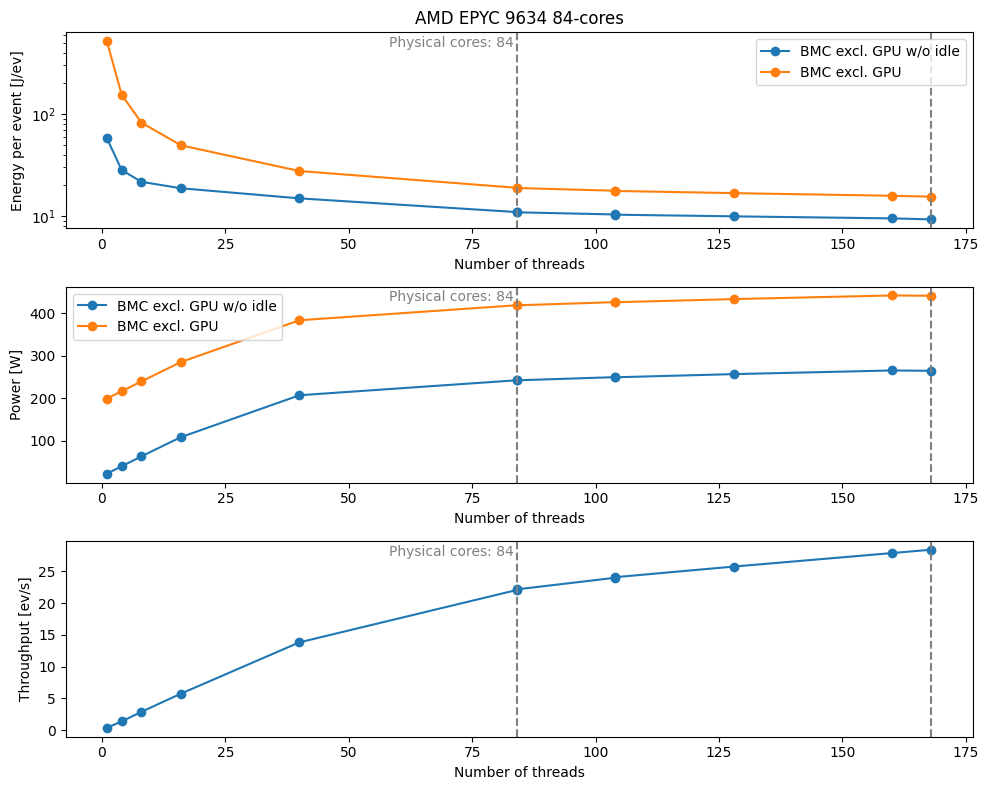

In [166]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))


ax1.plot(
    plot_df["cores"],
    plot_df["j_per_ev_bmc_no_gpu_wo_idle"],
    label="BMC excl. GPU w/o idle",
    marker="o",
)
ax1.plot(
    plot_df["cores"], plot_df["j_per_ev_bmc_no_gpu"], label="BMC excl. GPU", marker="o"
)
ax3.plot(
    plot_df["cores"],
    plot_df["throughput_events_slope_s"],
    label="Throughput [ev/s]",
    marker="o",
)

# ax2.fill_between(plot_df["cores"], plot_df["bmc_no_gpu_wo_idle_mean"] - plot_df["bmc_no_gpu_wo_idle_std"], plot_df["bmc_no_gpu_wo_idle_mean"] + plot_df["bmc_no_gpu_wo_idle_std"], alpha=0.5)
ax2.plot(
    plot_df["cores"],
    plot_df["bmc_no_gpu_wo_idle"],
    label="BMC excl. GPU w/o idle",
    marker="o",
)
# ax2.fill_between(plot_df["cores"], plot_df["bmc_no_gpu_mean"] - plot_df["bmc_no_gpu_std"], plot_df["bmc_no_gpu_mean"] + plot_df["bmc_no_gpu_std"], alpha=0.5)
ax2.plot(
    plot_df["cores"], plot_df["bmc_no_gpu"], label="BMC excl. GPU", marker="o"
)

ax1.set_ylabel("Energy per event [J/ev]")
ax1.set_yscale("log")
ax2.set_ylabel("Power [W]")
ax3.set_ylabel("Throughput [ev/s]")

J_per_kcal = 4184.0
kcal_bigmac = 500

f = 1e-6


ax1.legend()
ax2.legend()

for ax in (ax1, ax2, ax3):
    ax.set_xlabel("Number of threads")
    ax.axvline(84, color="gray", linestyle="--")
    ax.axvline(168, color="gray", linestyle="--")
    ax.text(
        s="Physical cores: 84",
        x=84 - 0.5,
        y=0.98,
        ha="right",
        va="top",
        transform=ax.get_xaxis_transform(),
        color="gray",
    )

ax1.set_title("AMD EPYC 9634 84-cores")

fig.tight_layout()
fig.savefig("j_per_ev_bmc_no_gpu_wo_idle.pdf")
fig.savefig("j_per_ev_bmc_no_gpu_wo_idle.png", dpi=300)
plt.show()

,cores,throughput_events_slope_s,end
17,1,0.269397,2025-06-20 14:43:45.432079
21,4,1.083604,2025-06-23 11:05:13.046362
20,8,2.187500,2025-06-23 10:42:37.653921
19,16,4.374006,2025-06-23 10:19:19.680763
18,32,8.410985,2025-06-20 15:04:28.313238
24,40,9.220412,2025-06-23 15:09:41.193117
23,48,10.058806,2025-06-23 14:07:42.529307
25,55,10.658765,2025-06-23 15:32:13.632345
22,64,11.237374,2025-06-23 11:39:12.955659


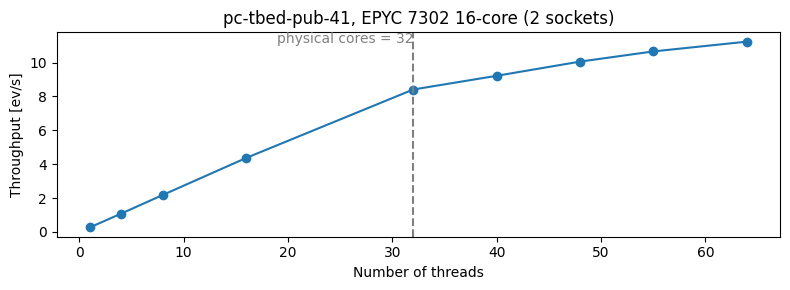

In [175]:
tdaq_df = run_df[(run_df.hostname == "pc-tbed-pub-41") & (run_df.start > datetime(year=2025, month=6, day=20)) & (run_df.end < datetime(year=2025, month=6, day=23, hour=15, minute=50))]

tdaq_df = tdaq_df.sort_values(by="cores")
display(tdaq_df[["cores", "throughput_events_slope_s", "end"]])

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(tdaq_df["cores"], tdaq_df["throughput_events_slope_s"], marker="o")

ax.set_title("pc-tbed-pub-41, EPYC 7302 16-core (2 sockets)")
ax.axvline(32, color="gray", linestyle="--")
ax.text(32, 1, "physical cores = 32", color="gray", ha="right", va="top", transform=ax.get_xaxis_transform())

ax.set_xlabel("Number of threads")
ax.set_ylabel("Throughput [ev/s]")

fig.tight_layout()
fig.savefig("throughput_events_slope_s_7302.pdf")
fig.savefig("throughput_events_slope_s_7302.png", dpi=300)


In [177]:
print(28.43 / 2305)
print(11.23 / 893)
print(28.43 / 2305 * 2605)
print(28.43 / 2305 * 3101)

0.01233405639913232
0.01257558790593505
32.130216919739695
38.24790889370932


In [176]:
hz_per_hs23 = 28.34 / 2305
for tdp, hs23, actJ in [
    (290, 2305, 9.299102),
    (2*155, 893, None),
    (2*210, 2605,  None),
    (2*360, 7450,  None),
    (2*210, 3101,  None),
]:
    w_per_hs23 = tdp / hs23
    print(f"W/HS23: {w_per_hs23}")

    J_per_ev = w_per_hs23 / hz_per_hs23
    print(f"J/ev: {J_per_ev} (act: {actJ})")
    

W/HS23: 0.12581344902386118
J/ev: 10.232886379675373 (act: 9.299102)
W/HS23: 0.3471444568868981
J/ev: 28.234579150469308 (act: None)
W/HS23: 0.16122840690978887
J/ev: 13.113319616339568 (act: None)
W/HS23: 0.09664429530201342
J/ev: 7.860448153533555 (act: None)
W/HS23: 0.13544018058690746
J/ev: 11.015865075964069 (act: None)
